# Granger Causality Analysis - Infant Resting State EEG

This notebook implements Granger causality analysis for the infant EEG dataset containing 103 subjects with 1-4 sessions each.

**Dataset**: NORB Infant EEG (BIDS 1.6.0 format)  
**Total Subjects**: 103 infants  
**Total Sessions**: 130 EEG recordings  
**Sampling Rate**: 200 Hz  
**Channel Count**: 19-21 channels per recording

---
## Section 1: Configuration and Parameters

All tunable parameters are centralized here for easy adjustment.

In [1]:
# ============================================================================
# CONFIGURATION AND PARAMETERS
# ============================================================================

import os
from pathlib import Path

# ----------------------------------------------------------------------------
# 1. DATA PARAMETERS
# ----------------------------------------------------------------------------

# Dataset paths
DATASET_BASE_PATH = Path('/home/alookaladdoo/DPCN-Project/Dataset')
DATASET_OVERVIEW_PATH = Path('/home/alookaladdoo/DPCN-Project/Dataset-Overview')

# Output directory structure
OUTPUT_BASE_PATH = Path('/home/alookaladdoo/DPCN-Project/results')
OUTPUT_DIRS = {
    'individual': OUTPUT_BASE_PATH / 'individual_subjects',
    'group': OUTPUT_BASE_PATH / 'group_level',
    'qc': OUTPUT_BASE_PATH / 'quality_control',
    'logs': OUTPUT_BASE_PATH / 'logs',
    'figures': OUTPUT_BASE_PATH / 'figures',
    'data': OUTPUT_BASE_PATH / 'processed_data'
}

# Subject handling
SUBJECT_LIST = 'auto'  # 'auto' to detect automatically, or provide list like ['sub-NORB00001', 'sub-NORB00002']
SESSION_HANDLING = 'all'  # 'all' to process all sessions, or 'first' for first session only

# File patterns
EEG_FILE_PATTERN = '*_task-EEG_eeg.edf'
CHANNELS_FILE_PATTERN = '*_task-EEG_channels.tsv'
EVENTS_FILE_PATTERN = '*_task-EEG_events.tsv'
ANNOTATIONS_FILE_PATTERN = '*_task-EEG_annotations.tsv'

# ----------------------------------------------------------------------------
# 2. PREPROCESSING PARAMETERS
# ----------------------------------------------------------------------------

# Filtering parameters
HIGHPASS_FREQ = 0.5  # High-pass filter cutoff in Hz
LOWPASS_FREQ = 30.0  # Low-pass filter cutoff in Hz
NOTCH_FREQ = 60.0  # Notch filter frequency (power line noise) in Hz
NOTCH_WIDTH = 2.0  # Notch filter width in Hz

# Resampling
TARGET_SFREQ = 200  # Target sampling frequency (None to keep original)

# Referencing
REFERENCE_TYPE = 'average'  # 'average', 'common', or None to keep original

# Bad channel detection
AUTO_BAD_CHANNELS = True  # Automatically detect bad channels
BAD_CHANNEL_THRESHOLD = 5.0  # Z-score threshold for bad channel detection
INTERPOLATE_BAD_CHANNELS = True  # Interpolate bad channels

# Artifact rejection
AMPLITUDE_THRESHOLD = 150  # Amplitude threshold in µV for artifact rejection
USE_DERIVATIVE_ANNOTATIONS = True  # Use visual inspection annotations from derivatives

# ----------------------------------------------------------------------------
# 3. SEGMENTATION PARAMETERS
# ----------------------------------------------------------------------------

# Window parameters
WINDOW_LENGTH = 10.0  # Window length in seconds
WINDOW_OVERLAP = 0.5  # Window overlap as fraction (0.5 = 50% overlap)
MIN_SEGMENT_DURATION = 5.0  # Minimum acceptable segment duration in seconds

# State selection
USE_EYES_CLOSED_ONLY = True  # Only use eyes-closed segments
MIN_EYES_CLOSED_DURATION = 2.0  # Minimum eyes-closed duration to include in seconds

# Segment quality
MIN_SEGMENTS_PER_SESSION = 3  # Minimum number of clean segments required per session
MAX_SEGMENTS_PER_SESSION = 50  # Maximum number of segments to use per session

# ----------------------------------------------------------------------------
# 4. GRANGER CAUSALITY PARAMETERS
# ----------------------------------------------------------------------------

# Model order selection
MODEL_ORDER_METHOD = 'aic'  # 'aic', 'bic', 'hqc', or 'fixed'
FIXED_MODEL_ORDER = 10  # Used if MODEL_ORDER_METHOD = 'fixed'
MIN_MODEL_ORDER = 1  # Minimum model order to test
MAX_MODEL_ORDER = 50  # Maximum model order to test

# GC computation
GC_METHOD = 'time_domain'  # 'time_domain' or 'frequency_domain'
COMPUTE_SPECTRAL_GC = True  # Compute frequency-band specific GC
COMPUTE_CONDITIONAL_GC = False  # Compute conditional GC (more computationally intensive)

# Frequency bands for spectral analysis
FREQUENCY_BANDS = {
    'delta': (0.5, 4.0),
    'theta': (4.0, 8.0),
    'alpha': (8.0, 13.0),
    'beta': (13.0, 30.0),
    'gamma': (30.0, 50.0)  # Only if lowpass allows
}

# Stationarity testing
CHECK_STATIONARITY = True  # Test for stationarity before GC computation
STATIONARITY_ALPHA = 0.05  # Significance level for stationarity tests
DIFFERENCE_IF_NONSTATIONARY = False  # Apply differencing if non-stationary

# ----------------------------------------------------------------------------
# 5. STATISTICAL PARAMETERS
# ----------------------------------------------------------------------------

# Significance testing
ALPHA = 0.05  # Significance threshold
MULTIPLE_COMPARISON_METHOD = 'fdr_bh'  # 'fdr_bh', 'bonferroni', 'permutation', or None

# Permutation testing
USE_PERMUTATION_TESTING = True  # Use permutation tests for significance
N_PERMUTATIONS = 1000  # Number of permutation iterations
PERMUTATION_METHOD = 'phase_randomization'  # 'phase_randomization' or 'time_shift'

# Confidence intervals
CONFIDENCE_LEVEL = 0.95  # Confidence interval level

# Effect size
COMPUTE_EFFECT_SIZE = True  # Compute Cohen's d or similar effect sizes

# ----------------------------------------------------------------------------
# 6. ANALYSIS PARAMETERS
# ----------------------------------------------------------------------------

# GC computation scope
PAIRWISE_GC = True  # Compute pairwise GC
CONDITIONAL_GC = False  # Compute conditional GC (controls for other channels)

# Channel selection
CHANNELS_TO_ANALYZE = 'all'  # 'all' or list of channel names
# Example: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2']

# Directionality
COMPUTE_BIDIRECTIONAL = True  # Compute both X→Y and Y→X

# Age grouping for stratified analysis
AGE_BINS = [0, 3, 6, 9, 12]  # Age bins in months
AGE_BIN_LABELS = ['0-3mo', '3-6mo', '6-9mo', '9-12mo']

# Longitudinal analysis
ANALYZE_LONGITUDINAL = True  # Perform within-subject session comparisons
MIN_SESSIONS_FOR_LONGITUDINAL = 2  # Minimum sessions required for longitudinal analysis

# ----------------------------------------------------------------------------
# 7. NETWORK ANALYSIS PARAMETERS
# ----------------------------------------------------------------------------

# Graph construction
NETWORK_THRESHOLD_METHOD = 'percentile'  # 'percentile', 'absolute', or 'significance'
NETWORK_THRESHOLD_VALUE = 90  # Percentile (if percentile method) or absolute threshold

# Hub identification
HUB_PERCENTILE = 90  # Percentile threshold for hub identification

# Community detection
COMMUNITY_DETECTION_METHOD = 'louvain'  # 'louvain', 'modularity', or 'label_propagation'

# Network metrics to compute
COMPUTE_NETWORK_METRICS = [
    'degree',
    'in_degree',
    'out_degree',
    'betweenness',
    'closeness',
    'clustering',
    'eigenvector_centrality'
]

# ----------------------------------------------------------------------------
# 8. VISUALIZATION PARAMETERS
# ----------------------------------------------------------------------------

# General plotting
FIGURE_DPI = 300  # Resolution for saved figures
FIGURE_FORMAT = 'png'  # 'png', 'pdf', 'svg'
FIGURE_SIZE = (10, 8)  # Default figure size in inches

# Color schemes
COLORMAP_GC = 'viridis'  # Colormap for GC matrices
COLORMAP_PVALUES = 'RdYlGn_r'  # Colormap for p-value matrices
COLORMAP_NETWORK = 'coolwarm'  # Colormap for network visualizations

# Plot generation control
GENERATE_INDIVIDUAL_PLOTS = True  # Generate plots for each subject/session
GENERATE_GROUP_PLOTS = True  # Generate group-level plots
GENERATE_INTERACTIVE_PLOTS = True  # Generate interactive HTML plots

# Plot types to generate
PLOT_TYPES = [
    'connectivity_matrix',
    'network_graph',
    'circular_plot',
    'topographic_map',
    'spectral_gc'
]

# Network visualization
NODE_SIZE_SCALE = 300  # Base node size for network plots
EDGE_WIDTH_SCALE = 3  # Scaling factor for edge width
NETWORK_LAYOUT = 'spring'  # 'spring', 'circular', 'kamada_kawai', or 'electrode_positions'

# ----------------------------------------------------------------------------
# 9. COMPUTATIONAL PARAMETERS
# ----------------------------------------------------------------------------

# Parallel processing
N_JOBS = -1  # Number of parallel jobs (-1 uses all available cores)
PARALLEL_BACKEND = 'loky'  # 'loky', 'threading', or 'multiprocessing'

# Memory management
MAX_MEMORY_PER_JOB = '2G'  # Maximum memory per parallel job
CACHE_INTERMEDIATE_RESULTS = True  # Cache intermediate results to disk

# Computation control
VERBOSE = 1  # Verbosity level (0=silent, 1=progress, 2=detailed)
RANDOM_SEED = 42  # Random seed for reproducibility
SAVE_INTERMEDIATE = True  # Save intermediate results during batch processing

# Error handling
CONTINUE_ON_ERROR = True  # Continue processing if individual subject fails
MAX_RETRIES = 2  # Maximum number of retries for failed subjects

# ----------------------------------------------------------------------------
# 10. QUALITY CONTROL PARAMETERS
# ----------------------------------------------------------------------------

# Data quality thresholds
MIN_RECORDING_DURATION = 60  # Minimum recording duration in seconds
MIN_CLEAN_DATA_RATIO = 0.3  # Minimum ratio of clean data after artifact rejection

# Model validation
CHECK_RESIDUAL_WHITENESS = True  # Test VAR model residual whiteness
CHECK_MODEL_STABILITY = True  # Check VAR model stability (eigenvalues)

# Result validation
VALIDATE_GC_RANGE = True  # Check if GC values are in reasonable range
FLAG_OUTLIERS = True  # Flag subjects with outlier values
OUTLIER_Z_THRESHOLD = 3.0  # Z-score threshold for outlier flagging

# ----------------------------------------------------------------------------
# 11. OUTPUT CONTROL
# ----------------------------------------------------------------------------

# File formats for saving
SAVE_NUMPY_ARRAYS = True  # Save GC matrices as .npy files
SAVE_CSV_TABLES = True  # Save summary tables as CSV
SAVE_JSON_METADATA = True  # Save metadata as JSON
SAVE_EXCEL_REPORTS = True  # Save comprehensive reports as Excel

# Compression
COMPRESS_OUTPUTS = True  # Compress large output files
COMPRESSION_FORMAT = 'npz'  # 'npz' or 'gzip'

# Logging
LOG_LEVEL = 'INFO'  # 'DEBUG', 'INFO', 'WARNING', 'ERROR'
LOG_TO_FILE = True  # Save logs to file
LOG_TO_CONSOLE = True  # Print logs to console

print("✓ Configuration parameters loaded successfully")
print(f"  Dataset path: {DATASET_BASE_PATH}")
print(f"  Output path: {OUTPUT_BASE_PATH}")
print(f"  Parallel jobs: {N_JOBS}")
print(f"  Random seed: {RANDOM_SEED}")

✓ Configuration parameters loaded successfully
  Dataset path: /home/alookaladdoo/DPCN-Project/Dataset
  Output path: /home/alookaladdoo/DPCN-Project/results
  Parallel jobs: -1
  Random seed: 42


### Create Output Directory Structure

In [2]:
# Create all output directories
for dir_name, dir_path in OUTPUT_DIRS.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {dir_path}")

# Create subdirectories for different analysis types
subdirs = {
    'matrices': OUTPUT_DIRS['data'] / 'gc_matrices',
    'spectral': OUTPUT_DIRS['data'] / 'spectral_gc',
    'network': OUTPUT_DIRS['data'] / 'network_metrics',
    'statistics': OUTPUT_DIRS['data'] / 'statistics',
    'individual_plots': OUTPUT_DIRS['figures'] / 'individual',
    'group_plots': OUTPUT_DIRS['figures'] / 'group',
    'interactive': OUTPUT_DIRS['figures'] / 'interactive',
}

for subdir_name, subdir_path in subdirs.items():
    subdir_path.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Output directory structure created successfully")
print(f"  Total directories created: {len(OUTPUT_DIRS) + len(subdirs)}")

✓ Created directory: /home/alookaladdoo/DPCN-Project/results/individual_subjects
✓ Created directory: /home/alookaladdoo/DPCN-Project/results/group_level
✓ Created directory: /home/alookaladdoo/DPCN-Project/results/quality_control
✓ Created directory: /home/alookaladdoo/DPCN-Project/results/logs
✓ Created directory: /home/alookaladdoo/DPCN-Project/results/figures
✓ Created directory: /home/alookaladdoo/DPCN-Project/results/processed_data

✓ Output directory structure created successfully
  Total directories created: 13


### Save Configuration to File

In [3]:
import json
from datetime import datetime

# Collect all configuration parameters
config = {
    'analysis_info': {
        'created': datetime.now().isoformat(),
        'dataset': 'NORB Infant EEG',
        'total_subjects': 103,
        'total_sessions': 130,
    },
    'data_parameters': {
        'dataset_base_path': str(DATASET_BASE_PATH),
        'output_base_path': str(OUTPUT_BASE_PATH),
        'subject_list': SUBJECT_LIST,
        'session_handling': SESSION_HANDLING,
    },
    'preprocessing': {
        'highpass_freq': HIGHPASS_FREQ,
        'lowpass_freq': LOWPASS_FREQ,
        'notch_freq': NOTCH_FREQ,
        'notch_width': NOTCH_WIDTH,
        'target_sfreq': TARGET_SFREQ,
        'reference_type': REFERENCE_TYPE,
        'auto_bad_channels': AUTO_BAD_CHANNELS,
        'interpolate_bad_channels': INTERPOLATE_BAD_CHANNELS,
        'amplitude_threshold': AMPLITUDE_THRESHOLD,
    },
    'segmentation': {
        'window_length': WINDOW_LENGTH,
        'window_overlap': WINDOW_OVERLAP,
        'min_segment_duration': MIN_SEGMENT_DURATION,
        'use_eyes_closed_only': USE_EYES_CLOSED_ONLY,
        'min_segments_per_session': MIN_SEGMENTS_PER_SESSION,
        'max_segments_per_session': MAX_SEGMENTS_PER_SESSION,
    },
    'granger_causality': {
        'model_order_method': MODEL_ORDER_METHOD,
        'fixed_model_order': FIXED_MODEL_ORDER,
        'min_model_order': MIN_MODEL_ORDER,
        'max_model_order': MAX_MODEL_ORDER,
        'gc_method': GC_METHOD,
        'compute_spectral_gc': COMPUTE_SPECTRAL_GC,
        'frequency_bands': FREQUENCY_BANDS,
        'check_stationarity': CHECK_STATIONARITY,
    },
    'statistics': {
        'alpha': ALPHA,
        'multiple_comparison_method': MULTIPLE_COMPARISON_METHOD,
        'use_permutation_testing': USE_PERMUTATION_TESTING,
        'n_permutations': N_PERMUTATIONS,
        'confidence_level': CONFIDENCE_LEVEL,
    },
    'analysis': {
        'pairwise_gc': PAIRWISE_GC,
        'conditional_gc': CONDITIONAL_GC,
        'channels_to_analyze': CHANNELS_TO_ANALYZE,
        'age_bins': AGE_BINS,
        'analyze_longitudinal': ANALYZE_LONGITUDINAL,
    },
    'network_analysis': {
        'threshold_method': NETWORK_THRESHOLD_METHOD,
        'threshold_value': NETWORK_THRESHOLD_VALUE,
        'hub_percentile': HUB_PERCENTILE,
        'community_detection_method': COMMUNITY_DETECTION_METHOD,
    },
    'visualization': {
        'figure_dpi': FIGURE_DPI,
        'figure_format': FIGURE_FORMAT,
        'colormap_gc': COLORMAP_GC,
        'generate_individual_plots': GENERATE_INDIVIDUAL_PLOTS,
        'generate_group_plots': GENERATE_GROUP_PLOTS,
    },
    'computational': {
        'n_jobs': N_JOBS,
        'parallel_backend': PARALLEL_BACKEND,
        'random_seed': RANDOM_SEED,
        'verbose': VERBOSE,
    },
}

# Save configuration to JSON file
config_file = OUTPUT_DIRS['logs'] / 'analysis_configuration.json'
with open(config_file, 'w') as f:
    json.dump(config, f, indent=2)

print(f"✓ Configuration saved to: {config_file}")

# Also save a human-readable version
config_txt = OUTPUT_DIRS['logs'] / 'analysis_configuration.txt'
with open(config_txt, 'w') as f:
    f.write("="*80 + "\n")
    f.write("GRANGER CAUSALITY ANALYSIS - CONFIGURATION\n")
    f.write("="*80 + "\n\n")
    
    for section, params in config.items():
        f.write(f"\n{section.upper().replace('_', ' ')}\n")
        f.write("-" * 80 + "\n")
        for key, value in params.items():
            f.write(f"  {key}: {value}\n")

print(f"✓ Human-readable configuration saved to: {config_txt}")
print("\n" + "="*80)
print("SECTION 1 COMPLETE: Configuration and Parameters")
print("="*80)

✓ Configuration saved to: /home/alookaladdoo/DPCN-Project/results/logs/analysis_configuration.json
✓ Human-readable configuration saved to: /home/alookaladdoo/DPCN-Project/results/logs/analysis_configuration.txt

SECTION 1 COMPLETE: Configuration and Parameters


### Parameter Summary

The configuration is now complete. Key parameters:

**Preprocessing:**
- Bandpass filter: 0.5-30 Hz
- Notch filter: 60 Hz (power line)
- Reference: Average reference
- Sampling rate: 200 Hz

**Segmentation:**
- Window length: 10 seconds
- Overlap: 50%
- Eyes-closed segments only

**Granger Causality:**
- Model order: AIC-based selection (1-50 lags)
- Method: Time-domain
- Spectral GC: Enabled (5 frequency bands)

**Statistics:**
- Significance: α = 0.05
- Multiple comparison: FDR correction
- Permutation testing: 1000 iterations

**Computational:**
- Parallel processing: All available cores
- Random seed: 42 (reproducibility)

All parameters can be easily modified in the configuration block above.

---
## Section 2: Environment Setup and Imports

Load all necessary libraries and verify installation.

### Import Core Libraries

In [4]:
# Core scientific computing libraries
import numpy as np
import pandas as pd
import scipy
from scipy import signal, stats
from scipy.fft import fft, ifft

# System and file handling
import sys
import glob
import warnings
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm

# Set numpy random seed for reproducibility
np.random.seed(RANDOM_SEED)

print("✓ Core libraries imported")
print(f"  NumPy version: {np.__version__}")
print(f"  Pandas version: {pd.__version__}")
print(f"  SciPy version: {scipy.__version__}")

✓ Core libraries imported
  NumPy version: 2.2.6
  Pandas version: 2.2.3
  SciPy version: 1.16.2


### Import EEG Processing Libraries

In [5]:
# MNE for EEG processing
try:
    import mne
    from mne.io import read_raw_edf
    # Note: psd_welch deprecated, use raw.compute_psd() method instead in newer MNE versions
    print(f"✓ MNE-Python version: {mne.__version__}")
except ImportError:
    print("⚠ MNE-Python not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mne"])
    import mne
    from mne.io import read_raw_edf
    print(f"✓ MNE-Python version: {mne.__version__}")

# pyEDFlib for reading EDF files (alternative/backup)
try:
    import pyedflib
    print(f"✓ pyEDFlib version: {pyedflib.__version__}")
except ImportError:
    print("⚠ pyEDFlib not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyedflib"])
    import pyedflib
    print(f"✓ pyEDFlib version: {pyedflib.__version__}")

# Set MNE logging level
mne.set_log_level(LOG_LEVEL if LOG_LEVEL != 'DEBUG' else 'INFO')

✓ MNE-Python version: 1.10.2
✓ pyEDFlib version: 0.1.42


### Import Statistical Modeling Libraries

In [6]:
# Statsmodels for VAR models and Granger causality
try:
    import statsmodels.api as sm
    from statsmodels.tsa.api import VAR
    from statsmodels.tsa.stattools import grangercausalitytests, adfuller
    from statsmodels.stats.multitest import multipletests
    print(f"✓ Statsmodels version: {sm.__version__}")
except ImportError:
    print("⚠ Statsmodels not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    import statsmodels.api as sm
    from statsmodels.tsa.api import VAR
    from statsmodels.tsa.stattools import grangercausalitytests, adfuller
    from statsmodels.stats.multitest import multipletests
    print(f"✓ Statsmodels version: {sm.__version__}")

# Scikit-learn for preprocessing and utilities
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    import sklearn
    print(f"✓ Scikit-learn version: {sklearn.__version__}")
except ImportError:
    print("⚠ Scikit-learn not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    import sklearn
    print(f"✓ Scikit-learn version: {sklearn.__version__}")

✓ Statsmodels version: 0.14.5
✓ Scikit-learn version: 1.7.2


### Import Visualization Libraries

In [7]:
# Matplotlib for static plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
print(f"✓ Matplotlib version: {matplotlib.__version__}")

# Seaborn for statistical visualizations
try:
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)
    print(f"✓ Seaborn version: {sns.__version__}")
except ImportError:
    print("⚠ Seaborn not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)
    print(f"✓ Seaborn version: {sns.__version__}")

# Plotly for interactive visualizations
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    import plotly
    print(f"✓ Plotly version: {plotly.__version__}")
except ImportError:
    print("⚠ Plotly not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    import plotly
    print(f"✓ Plotly version: {plotly.__version__}")

# Configure matplotlib defaults
plt.rcParams['figure.dpi'] = FIGURE_DPI
plt.rcParams['figure.figsize'] = FIGURE_SIZE
plt.rcParams['savefig.dpi'] = FIGURE_DPI
plt.rcParams['savefig.bbox'] = 'tight'

# Set matplotlib backend for notebook
%matplotlib inline

print("✓ Visualization settings configured")

✓ Matplotlib version: 3.10.6
✓ Seaborn version: 0.13.2
✓ Plotly version: 6.3.1
✓ Visualization settings configured


### Import Network Analysis Libraries

In [8]:
# NetworkX for graph analysis
try:
    import networkx as nx
    print(f"✓ NetworkX version: {nx.__version__}")
except ImportError:
    print("⚠ NetworkX not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"])
    import networkx as nx
    print(f"✓ NetworkX version: {nx.__version__}")

# Community detection (optional, for advanced network analysis)
try:
    import community.community_louvain as community_louvain
    print(f"✓ Community detection (python-louvain) available")
except ImportError:
    print("⚠ python-louvain not found. Installing...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "python-louvain"])
        import community.community_louvain as community_louvain
        print(f"✓ Community detection (python-louvain) available")
    except:
        print("  Note: Community detection will use NetworkX alternatives")
        community_louvain = None

✓ NetworkX version: 3.5
✓ Community detection (python-louvain) available


### Import Parallel Processing Libraries

In [9]:
# Joblib for parallel processing
try:
    from joblib import Parallel, delayed, Memory
    import joblib
    print(f"✓ Joblib version: {joblib.__version__}")
except ImportError:
    print("⚠ Joblib not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "joblib"])
    from joblib import Parallel, delayed, Memory
    import joblib
    print(f"✓ Joblib version: {joblib.__version__}")

# Multiprocessing (built-in)
import multiprocessing as mp
n_cores = mp.cpu_count()
print(f"✓ Multiprocessing available")
print(f"  Available CPU cores: {n_cores}")
print(f"  Will use: {N_JOBS if N_JOBS > 0 else n_cores} cores for parallel processing")

✓ Joblib version: 1.5.2
✓ Multiprocessing available
  Available CPU cores: 16
  Will use: 16 cores for parallel processing


### Configure Logging

In [10]:
import logging
from logging.handlers import RotatingFileHandler

# Create logger
logger = logging.getLogger('GrangerCausality')
logger.setLevel(getattr(logging, LOG_LEVEL))

# Clear any existing handlers
logger.handlers = []

# Create formatters
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Console handler
if LOG_TO_CONSOLE:
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(getattr(logging, LOG_LEVEL))
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

# File handler
if LOG_TO_FILE:
    log_file = OUTPUT_DIRS['logs'] / f'analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
    file_handler = RotatingFileHandler(
        log_file, 
        maxBytes=10*1024*1024,  # 10 MB
        backupCount=5
    )
    file_handler.setLevel(getattr(logging, LOG_LEVEL))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    print(f"✓ Logging configured (Level: {LOG_LEVEL})")
    print(f"  Log file: {log_file}")
else:
    print(f"✓ Logging configured (Level: {LOG_LEVEL}, Console only)")

# Suppress warnings if needed
if VERBOSE == 0:
    warnings.filterwarnings('ignore')
    logger.info("Warnings suppressed")
    
logger.info("="*80)
logger.info("Granger Causality Analysis - Session Started")
logger.info("="*80)

✓ Logging configured (Level: INFO)
  Log file: /home/alookaladdoo/DPCN-Project/results/logs/analysis_20251025_144919.log
2025-10-25 14:49:19 - GrangerCausality - INFO - ================================================================================
2025-10-25 14:49:19 - GrangerCausality - INFO - Granger Causality Analysis - Session Started
2025-10-25 14:49:19 - GrangerCausality - INFO - ================================================================================
2025-10-25 14:49:19 - GrangerCausality - INFO - Granger Causality Analysis - Session Started
2025-10-25 14:49:19 - GrangerCausality - INFO - ================================================================================


### Verify Environment and Display Summary

In [11]:
# Create a summary of the environment
environment_info = {
    'Python': sys.version.split()[0],
    'NumPy': np.__version__,
    'Pandas': pd.__version__,
    'SciPy': scipy.__version__,
    'MNE': mne.__version__,
    'Statsmodels': sm.__version__,
    'Scikit-learn': sklearn.__version__,
    'Matplotlib': matplotlib.__version__,
    'Seaborn': sns.__version__,
    'Plotly': plotly.__version__,
    'NetworkX': nx.__version__,
    'Joblib': joblib.__version__,
}

# Display environment summary
print("\n" + "="*80)
print("ENVIRONMENT SUMMARY")
print("="*80)
for package, version in environment_info.items():
    print(f"  {package:.<20} {version}")

print("\n" + "-"*80)
print("SYSTEM INFORMATION")
print("-"*80)
print(f"  Operating System: {sys.platform}")
print(f"  CPU Cores: {n_cores}")
print(f"  Parallel Jobs: {N_JOBS if N_JOBS > 0 else n_cores}")
print(f"  Random Seed: {RANDOM_SEED}")

# Save environment info to file
env_file = OUTPUT_DIRS['logs'] / 'environment_info.json'
with open(env_file, 'w') as f:
    json.dump({
        'environment': environment_info,
        'system': {
            'platform': sys.platform,
            'python_version': sys.version,
            'cpu_cores': n_cores,
            'n_jobs': N_JOBS if N_JOBS > 0 else n_cores,
        },
        'timestamp': datetime.now().isoformat()
    }, f, indent=2)

print(f"\n✓ Environment information saved to: {env_file}")

# Log environment info
logger.info("Environment setup complete")
for package, version in environment_info.items():
    logger.debug(f"{package}: {version}")

print("\n" + "="*80)
print("SECTION 2 COMPLETE: Environment Setup and Imports")
print("="*80)


ENVIRONMENT SUMMARY
  Python.............. 3.13.7
  NumPy............... 2.2.6
  Pandas.............. 2.2.3
  SciPy............... 1.16.2
  MNE................. 1.10.2
  Statsmodels......... 0.14.5
  Scikit-learn........ 1.7.2
  Matplotlib.......... 3.10.6
  Seaborn............. 0.13.2
  Plotly.............. 6.3.1
  NetworkX............ 3.5
  Joblib.............. 1.5.2

--------------------------------------------------------------------------------
SYSTEM INFORMATION
--------------------------------------------------------------------------------
  Operating System: linux
  CPU Cores: 16
  Parallel Jobs: 16
  Random Seed: 42

✓ Environment information saved to: /home/alookaladdoo/DPCN-Project/results/logs/environment_info.json
2025-10-25 14:49:19 - GrangerCausality - INFO - Environment setup complete

SECTION 2 COMPLETE: Environment Setup and Imports

SECTION 2 COMPLETE: Environment Setup and Imports


---
## Section 3: Data Discovery and Inventory

Scan the dataset and create a comprehensive inventory of all available data.

### Load Participant Metadata

In [12]:
# Load participants.tsv file
participants_file = DATASET_BASE_PATH / 'participants.tsv'

if not participants_file.exists():
    logger.error(f"Participants file not found: {participants_file}")
    raise FileNotFoundError(f"Participants file not found: {participants_file}")

# Read participant metadata
participants_df = pd.read_csv(participants_file, sep='\t')
logger.info(f"Loaded {len(participants_df)} participants from {participants_file}")

print(f"✓ Loaded participant metadata: {len(participants_df)} subjects")
print(f"\nParticipants DataFrame:")
print(participants_df.head(10))
print(f"\nSex distribution:")
print(participants_df['sex'].value_counts())

# Log the sex distribution
for sex, count in participants_df['sex'].value_counts().items():
    logger.info(f"  Sex {sex}: {count} subjects")

2025-10-25 14:49:19 - GrangerCausality - INFO - Loaded 103 participants from /home/alookaladdoo/DPCN-Project/Dataset/participants.tsv
✓ Loaded participant metadata: 103 subjects

Participants DataFrame:
  participant_id sex
0  sub-NORB00001   M
1  sub-NORB00002   M
2  sub-NORB00003   F
3  sub-NORB00004   M
4  sub-NORB00005   M
5  sub-NORB00006   M
6  sub-NORB00007   M
7  sub-NORB00008   M
8  sub-NORB00009   F
9  sub-NORB00010   M

Sex distribution:
sex
M    62
F    41
Name: count, dtype: int64
2025-10-25 14:49:19 - GrangerCausality - INFO -   Sex M: 62 subjects
2025-10-25 14:49:19 - GrangerCausality - INFO -   Sex F: 41 subjects
✓ Loaded participant metadata: 103 subjects

Participants DataFrame:
  participant_id sex
0  sub-NORB00001   M
1  sub-NORB00002   M
2  sub-NORB00003   F
3  sub-NORB00004   M
4  sub-NORB00005   M
5  sub-NORB00006   M
6  sub-NORB00007   M
7  sub-NORB00008   M
8  sub-NORB00009   F
9  sub-NORB00010   M

Sex distribution:
sex
M    62
F    41
Name: count, dtype: int6

### Scan Dataset Directory Structure

In [13]:
def scan_subject_sessions(subject_id):
    """
    Scan all sessions for a given subject.
    
    Parameters:
    -----------
    subject_id : str
        Subject identifier (e.g., 'sub-NORB00001')
    
    Returns:
    --------
    list : List of session directories found
    """
    subject_path = DATASET_BASE_PATH / subject_id
    
    if not subject_path.exists():
        logger.warning(f"Subject directory not found: {subject_path}")
        return []
    
    # Find all session directories
    sessions = sorted([d.name for d in subject_path.iterdir() if d.is_dir() and d.name.startswith('ses-')])
    
    return sessions


def get_eeg_file_info(subject_id, session_id):
    """
    Get EEG file information for a specific subject and session.
    
    Parameters:
    -----------
    subject_id : str
        Subject identifier
    session_id : str
        Session identifier (e.g., 'ses-1')
    
    Returns:
    --------
    dict : Dictionary with EEG file information
    """
    info = {
        'subject_id': subject_id,
        'session_id': session_id,
        'eeg_file_path': None,
        'eeg_file_exists': False,
        'channels_file_exists': False,
        'events_file_exists': False,
        'annotations_file_exists': False,
        'duration_sec': None,
        'n_channels': None,
        'age_years': None,
        'age_months': None,
    }
    
    # Construct paths
    session_path = DATASET_BASE_PATH / subject_id / session_id / 'eeg'
    scans_file = DATASET_BASE_PATH / subject_id / session_id / f'{subject_id}_{session_id}_scans.tsv'
    
    if not session_path.exists():
        logger.debug(f"EEG directory not found: {session_path}")
        return info
    
    # Find EEG file
    eeg_files = list(session_path.glob(EEG_FILE_PATTERN))
    if eeg_files:
        info['eeg_file_path'] = str(eeg_files[0])
        info['eeg_file_exists'] = True
    
    # Check for associated files
    channels_files = list(session_path.glob(CHANNELS_FILE_PATTERN))
    info['channels_file_exists'] = len(channels_files) > 0
    
    events_files = list(session_path.glob(EVENTS_FILE_PATTERN))
    info['events_file_exists'] = len(events_files) > 0
    
    # Check for derivative annotations
    derivatives_path = DATASET_BASE_PATH / 'derivatives' / 'NeuronicEEG' / subject_id / session_id / 'eeg'
    if derivatives_path.exists():
        annotations_files = list(derivatives_path.glob(ANNOTATIONS_FILE_PATTERN))
        info['annotations_file_exists'] = len(annotations_files) > 0
    
    # Read age from scans.tsv
    if scans_file.exists():
        try:
            scans_df = pd.read_csv(scans_file, sep='\t')
            if 'age_acq_time' in scans_df.columns and len(scans_df) > 0:
                info['age_years'] = scans_df['age_acq_time'].iloc[0]
                info['age_months'] = scans_df['age_acq_time'].iloc[0] * 12
        except Exception as e:
            logger.warning(f"Could not read age from {scans_file}: {e}")
    
    # Try to get duration and channel count from metadata
    if info['eeg_file_exists']:
        json_file = Path(info['eeg_file_path']).with_suffix('.json')
        if json_file.exists():
            try:
                with open(json_file, 'r') as f:
                    metadata = json.load(f)
                    info['duration_sec'] = metadata.get('RecordingDuration', None)
                    info['n_channels'] = metadata.get('EEGChannelCount', None)
            except Exception as e:
                logger.warning(f"Could not read metadata from {json_file}: {e}")
    
    return info


# Scan all subjects and sessions
logger.info("Starting dataset scan...")
print("Scanning dataset directory structure...")
print("This may take a minute...")

all_sessions_data = []

for _, row in tqdm(participants_df.iterrows(), total=len(participants_df), desc="Scanning subjects"):
    subject_id = row['participant_id']
    sex = row['sex']
    
    # Find all sessions for this subject
    sessions = scan_subject_sessions(subject_id)
    
    if not sessions:
        logger.warning(f"No sessions found for {subject_id}")
        continue
    
    # Get information for each session
    for session_id in sessions:
        session_info = get_eeg_file_info(subject_id, session_id)
        session_info['sex'] = sex
        session_info['session_count_for_subject'] = len(sessions)
        all_sessions_data.append(session_info)

# Create master inventory dataframe
inventory_df = pd.DataFrame(all_sessions_data)

logger.info(f"Dataset scan complete. Found {len(inventory_df)} sessions across {len(participants_df)} subjects")
print(f"\n✓ Dataset scan complete")
print(f"  Total sessions found: {len(inventory_df)}")
print(f"  Total subjects: {len(participants_df)}")

2025-10-25 14:49:19 - GrangerCausality - INFO - Starting dataset scan...
Scanning dataset directory structure...
This may take a minute...
Scanning dataset directory structure...
This may take a minute...


Scanning subjects:   0%|          | 0/103 [00:00<?, ?it/s]

2025-10-25 14:49:19 - GrangerCausality - INFO - Dataset scan complete. Found 130 sessions across 103 subjects

✓ Dataset scan complete
  Total sessions found: 130
  Total subjects: 103

✓ Dataset scan complete
  Total sessions found: 130
  Total subjects: 103


### Display Inventory Summary

In [14]:
# Display first few rows of inventory
print("\nInventory DataFrame (first 10 rows):")
print(inventory_df.head(10))

print("\n" + "="*80)
print("DATASET INVENTORY SUMMARY")
print("="*80)

# Basic counts
print(f"\nBasic Statistics:")
print(f"  Total subjects: {inventory_df['subject_id'].nunique()}")
print(f"  Total sessions: {len(inventory_df)}")
print(f"  Sessions with EEG data: {inventory_df['eeg_file_exists'].sum()}")
print(f"  Sessions with channels info: {inventory_df['channels_file_exists'].sum()}")
print(f"  Sessions with events: {inventory_df['events_file_exists'].sum()}")
print(f"  Sessions with annotations: {inventory_df['annotations_file_exists'].sum()}")

# Session count distribution
print(f"\nSession Count Distribution:")
session_counts = inventory_df.groupby('subject_id')['session_id'].count().value_counts().sort_index()
for n_sessions, n_subjects in session_counts.items():
    print(f"  {n_subjects} subjects with {n_sessions} session(s)")
    logger.info(f"{n_subjects} subjects with {n_sessions} session(s)")

# Sex distribution across sessions
print(f"\nSex Distribution (across all sessions):")
sex_dist = inventory_df['sex'].value_counts()
for sex, count in sex_dist.items():
    print(f"  Sex {sex}: {count} sessions")

# Age distribution
if inventory_df['age_months'].notna().any():
    print(f"\nAge Distribution:")
    print(f"  Mean age: {inventory_df['age_months'].mean():.2f} months")
    print(f"  Median age: {inventory_df['age_months'].median():.2f} months")
    print(f"  Min age: {inventory_df['age_months'].min():.2f} months")
    print(f"  Max age: {inventory_df['age_months'].max():.2f} months")
    print(f"  Std dev: {inventory_df['age_months'].std():.2f} months")
    
    logger.info(f"Age statistics: mean={inventory_df['age_months'].mean():.2f}, "
                f"median={inventory_df['age_months'].median():.2f}, "
                f"range=[{inventory_df['age_months'].min():.2f}, {inventory_df['age_months'].max():.2f}]")

# Duration distribution
if inventory_df['duration_sec'].notna().any():
    print(f"\nRecording Duration:")
    print(f"  Mean duration: {inventory_df['duration_sec'].mean():.1f} seconds")
    print(f"  Median duration: {inventory_df['duration_sec'].median():.1f} seconds")
    print(f"  Min duration: {inventory_df['duration_sec'].min():.1f} seconds")
    print(f"  Max duration: {inventory_df['duration_sec'].max():.1f} seconds")

# Channel count distribution
if inventory_df['n_channels'].notna().any():
    print(f"\nChannel Count Distribution:")
    channel_counts = inventory_df['n_channels'].value_counts().sort_index()
    for n_channels, count in channel_counts.items():
        print(f"  {int(n_channels)} channels: {count} sessions")

# Missing data report
print(f"\nMissing Data Report:")
print(f"  Sessions without EEG files: {(~inventory_df['eeg_file_exists']).sum()}")
print(f"  Sessions without age info: {inventory_df['age_months'].isna().sum()}")
print(f"  Sessions without duration info: {inventory_df['duration_sec'].isna().sum()}")
print(f"  Sessions without channel count: {inventory_df['n_channels'].isna().sum()}")


Inventory DataFrame (first 10 rows):
      subject_id session_id  \
0  sub-NORB00001      ses-1   
1  sub-NORB00002      ses-1   
2  sub-NORB00003      ses-1   
3  sub-NORB00004      ses-1   
4  sub-NORB00005      ses-1   
5  sub-NORB00006      ses-1   
6  sub-NORB00007      ses-1   
7  sub-NORB00008      ses-1   
8  sub-NORB00009      ses-1   
9  sub-NORB00010      ses-1   

                                       eeg_file_path  eeg_file_exists  \
0  /home/alookaladdoo/DPCN-Project/Dataset/sub-NO...             True   
1  /home/alookaladdoo/DPCN-Project/Dataset/sub-NO...             True   
2  /home/alookaladdoo/DPCN-Project/Dataset/sub-NO...             True   
3  /home/alookaladdoo/DPCN-Project/Dataset/sub-NO...             True   
4  /home/alookaladdoo/DPCN-Project/Dataset/sub-NO...             True   
5  /home/alookaladdoo/DPCN-Project/Dataset/sub-NO...             True   
6  /home/alookaladdoo/DPCN-Project/Dataset/sub-NO...             True   
7  /home/alookaladdoo/DPCN-Project/D

### Visualize Data Distribution

2025-10-25 14:49:20 - GrangerCausality - INFO - Saved dataset overview plot to /home/alookaladdoo/DPCN-Project/results/quality_control/dataset_overview.png


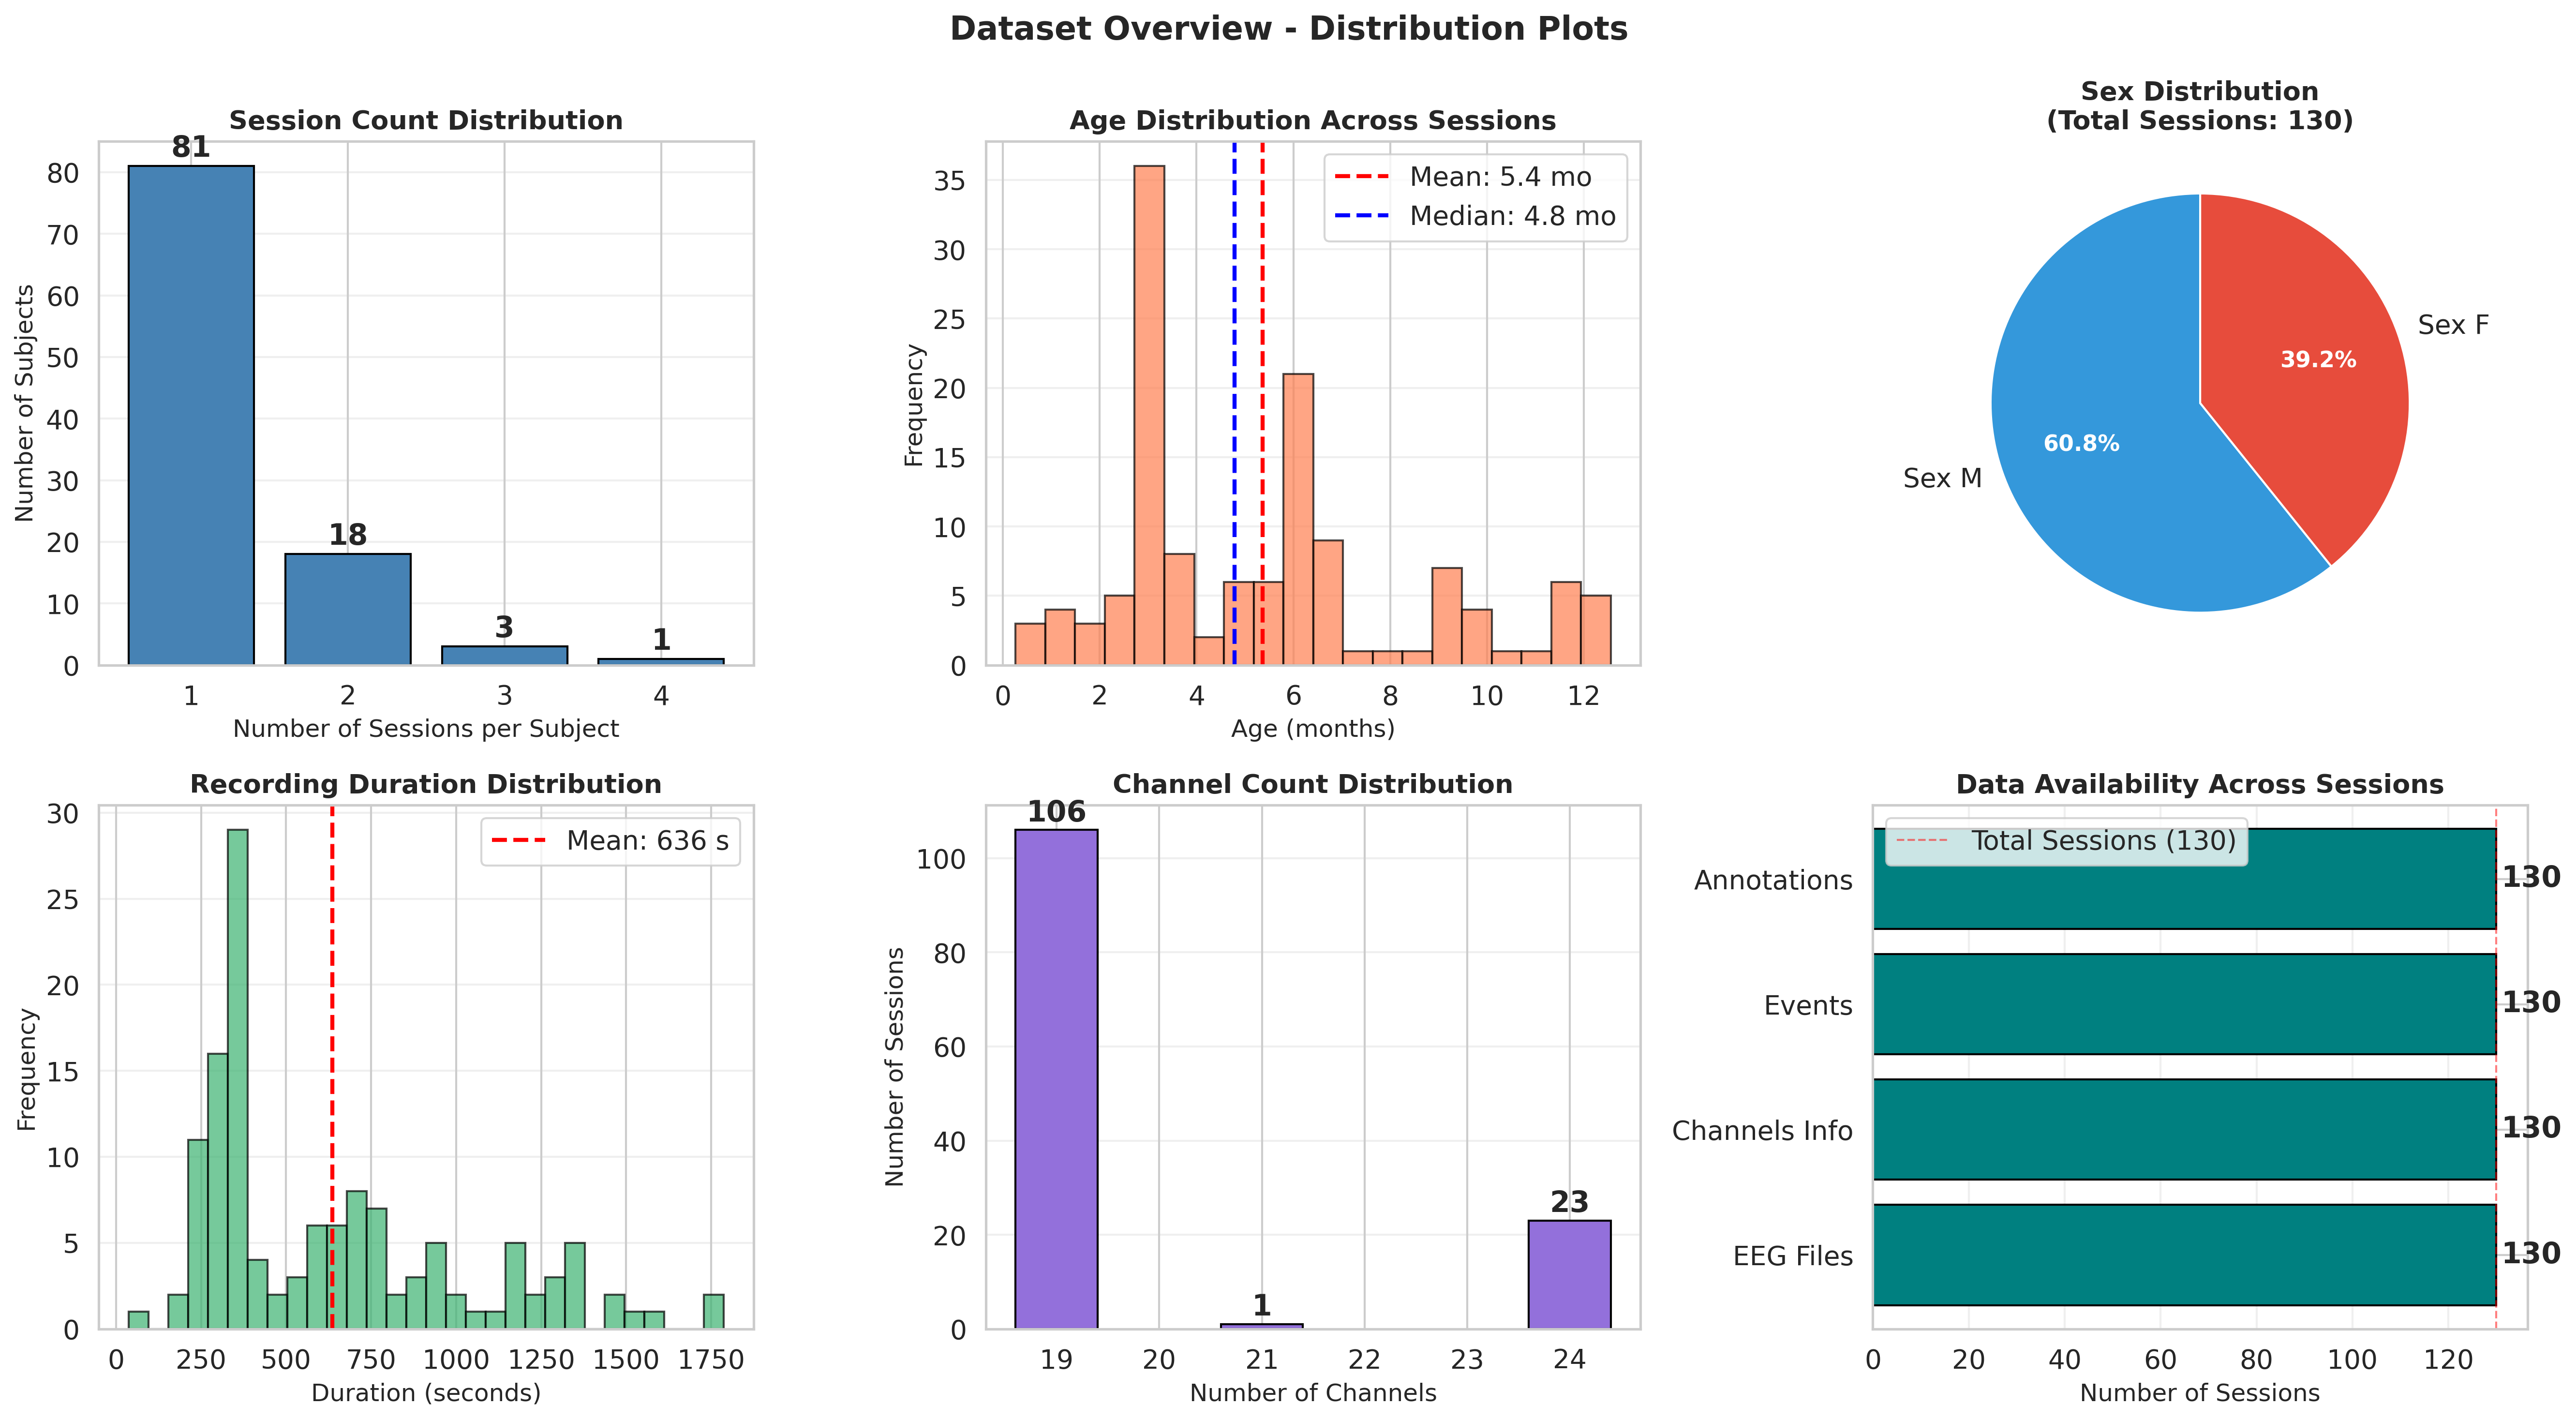


✓ Dataset overview visualization saved to: /home/alookaladdoo/DPCN-Project/results/quality_control/dataset_overview.png


In [15]:
# Create visualization of dataset characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Dataset Overview - Distribution Plots', fontsize=16, fontweight='bold')

# 1. Session count distribution
ax = axes[0, 0]
session_counts = inventory_df.groupby('subject_id')['session_id'].count().value_counts().sort_index()
ax.bar(session_counts.index, session_counts.values, color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Sessions per Subject', fontsize=12)
ax.set_ylabel('Number of Subjects', fontsize=12)
ax.set_title('Session Count Distribution', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(session_counts.values):
    ax.text(session_counts.index[i], v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# 2. Age distribution (histogram)
ax = axes[0, 1]
if inventory_df['age_months'].notna().any():
    ax.hist(inventory_df['age_months'].dropna(), bins=20, color='coral', edgecolor='black', alpha=0.7)
    ax.axvline(inventory_df['age_months'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {inventory_df["age_months"].mean():.1f} mo')
    ax.axvline(inventory_df['age_months'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {inventory_df["age_months"].median():.1f} mo')
    ax.set_xlabel('Age (months)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Age Distribution Across Sessions', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Age data not available', ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Age Distribution', fontsize=13, fontweight='bold')

# 3. Sex distribution
ax = axes[0, 2]
sex_dist = inventory_df['sex'].value_counts()
colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax.pie(sex_dist.values, labels=[f'Sex {s}' for s in sex_dist.index], 
                                     autopct='%1.1f%%', colors=colors, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)
ax.set_title(f'Sex Distribution\n(Total Sessions: {len(inventory_df)})', fontsize=13, fontweight='bold')

# 4. Recording duration distribution
ax = axes[1, 0]
if inventory_df['duration_sec'].notna().any():
    ax.hist(inventory_df['duration_sec'].dropna(), bins=30, color='mediumseagreen', edgecolor='black', alpha=0.7)
    ax.axvline(inventory_df['duration_sec'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {inventory_df["duration_sec"].mean():.0f} s')
    ax.set_xlabel('Duration (seconds)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Recording Duration Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Duration data not available', ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Recording Duration', fontsize=13, fontweight='bold')

# 5. Channel count distribution
ax = axes[1, 1]
if inventory_df['n_channels'].notna().any():
    channel_counts = inventory_df['n_channels'].value_counts().sort_index()
    ax.bar(channel_counts.index, channel_counts.values, color='mediumpurple', edgecolor='black')
    ax.set_xlabel('Number of Channels', fontsize=12)
    ax.set_ylabel('Number of Sessions', fontsize=12)
    ax.set_title('Channel Count Distribution', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    for i, (idx, v) in enumerate(channel_counts.items()):
        ax.text(idx, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
else:
    ax.text(0.5, 0.5, 'Channel count data not available', ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Channel Count', fontsize=13, fontweight='bold')

# 6. Data availability summary
ax = axes[1, 2]
availability_data = {
    'EEG Files': inventory_df['eeg_file_exists'].sum(),
    'Channels Info': inventory_df['channels_file_exists'].sum(),
    'Events': inventory_df['events_file_exists'].sum(),
    'Annotations': inventory_df['annotations_file_exists'].sum()
}
bars = ax.barh(list(availability_data.keys()), list(availability_data.values()), color='teal', edgecolor='black')
ax.set_xlabel('Number of Sessions', fontsize=12)
ax.set_title('Data Availability Across Sessions', fontsize=13, fontweight='bold')
ax.axvline(len(inventory_df), color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Total Sessions ({len(inventory_df)})')
ax.legend()
ax.grid(axis='x', alpha=0.3)
for i, v in enumerate(availability_data.values()):
    ax.text(v + 1, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIRS['qc'] / 'dataset_overview.png', dpi=FIGURE_DPI, bbox_inches='tight')
logger.info(f"Saved dataset overview plot to {OUTPUT_DIRS['qc'] / 'dataset_overview.png'}")
plt.show()

print(f"\n✓ Dataset overview visualization saved to: {OUTPUT_DIRS['qc'] / 'dataset_overview.png'}")

### Save Inventory Data

In [16]:
# Save inventory DataFrame to CSV
inventory_csv_path = OUTPUT_BASE_PATH / 'subject_session_inventory.csv'
inventory_df.to_csv(inventory_csv_path, index=False)
logger.info(f"Saved inventory DataFrame to {inventory_csv_path}")
print(f"✓ Inventory saved to: {inventory_csv_path}")
print(f"  Total sessions: {len(inventory_df)}")
print(f"  Total subjects: {inventory_df['subject_id'].nunique()}")

# Save detailed summary statistics to text file
summary_stats_path = OUTPUT_BASE_PATH / 'data_summary_statistics.txt'
with open(summary_stats_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("DATASET INVENTORY SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("OVERALL STATISTICS\n")
    f.write("-"*80 + "\n")
    f.write(f"Total number of subjects: {inventory_df['subject_id'].nunique()}\n")
    f.write(f"Total number of sessions: {len(inventory_df)}\n")
    f.write(f"Sessions per subject (mean ± std): {inventory_df.groupby('subject_id').size().mean():.2f} ± {inventory_df.groupby('subject_id').size().std():.2f}\n")
    f.write(f"Sessions per subject (range): {inventory_df.groupby('subject_id').size().min()} - {inventory_df.groupby('subject_id').size().max()}\n\n")
    
    f.write("SESSION COUNT DISTRIBUTION\n")
    f.write("-"*80 + "\n")
    session_counts = inventory_df.groupby('subject_id').size().value_counts().sort_index()
    for n_sessions, count in session_counts.items():
        f.write(f"  {n_sessions} session(s): {count} subjects\n")
    f.write("\n")
    
    f.write("SEX DISTRIBUTION\n")
    f.write("-"*80 + "\n")
    sex_dist = inventory_df['sex'].value_counts()
    for sex, count in sex_dist.items():
        percentage = (count / len(inventory_df)) * 100
        f.write(f"  Sex {sex}: {count} sessions ({percentage:.1f}%)\n")
    f.write("\n")
    
    if inventory_df['age_months'].notna().any():
        f.write("AGE STATISTICS (months)\n")
        f.write("-"*80 + "\n")
        f.write(f"  Mean: {inventory_df['age_months'].mean():.2f}\n")
        f.write(f"  Median: {inventory_df['age_months'].median():.2f}\n")
        f.write(f"  Std Dev: {inventory_df['age_months'].std():.2f}\n")
        f.write(f"  Range: {inventory_df['age_months'].min():.2f} - {inventory_df['age_months'].max():.2f}\n")
        f.write(f"  Missing: {inventory_df['age_months'].isna().sum()} sessions\n\n")
    
    if inventory_df['duration_sec'].notna().any():
        f.write("RECORDING DURATION (seconds)\n")
        f.write("-"*80 + "\n")
        f.write(f"  Mean: {inventory_df['duration_sec'].mean():.2f}\n")
        f.write(f"  Median: {inventory_df['duration_sec'].median():.2f}\n")
        f.write(f"  Std Dev: {inventory_df['duration_sec'].std():.2f}\n")
        f.write(f"  Range: {inventory_df['duration_sec'].min():.2f} - {inventory_df['duration_sec'].max():.2f}\n")
        f.write(f"  Missing: {inventory_df['duration_sec'].isna().sum()} sessions\n\n")
    
    if inventory_df['n_channels'].notna().any():
        f.write("CHANNEL COUNT DISTRIBUTION\n")
        f.write("-"*80 + "\n")
        channel_counts = inventory_df['n_channels'].value_counts().sort_index()
        for n_channels, count in channel_counts.items():
            f.write(f"  {int(n_channels)} channels: {count} sessions\n")
        f.write("\n")
    
    f.write("DATA AVAILABILITY\n")
    f.write("-"*80 + "\n")
    f.write(f"  EEG files present: {inventory_df['eeg_file_exists'].sum()} / {len(inventory_df)}\n")
    f.write(f"  Channels files present: {inventory_df['channels_file_exists'].sum()} / {len(inventory_df)}\n")
    f.write(f"  Events files present: {inventory_df['events_file_exists'].sum()} / {len(inventory_df)}\n")
    f.write(f"  Annotations present: {inventory_df['annotations_file_exists'].sum()} / {len(inventory_df)}\n\n")
    
    f.write("MISSING DATA REPORT\n")
    f.write("-"*80 + "\n")
    missing_eeg = inventory_df[~inventory_df['eeg_file_exists']]
    if len(missing_eeg) > 0:
        f.write(f"  Sessions with missing EEG files: {len(missing_eeg)}\n")
        for _, row in missing_eeg.iterrows():
            f.write(f"    - {row['subject_id']} / {row['session_id']}\n")
    else:
        f.write("  ✓ All sessions have EEG files present\n")
    f.write("\n")
    
    f.write("="*80 + "\n")

logger.info(f"Saved summary statistics to {summary_stats_path}")
print(f"✓ Summary statistics saved to: {summary_stats_path}")
print(f"\n{'='*80}")
print("SECTION 3 COMPLETE: Data Discovery and Inventory")
print(f"{'='*80}")

2025-10-25 14:49:21 - GrangerCausality - INFO - Saved inventory DataFrame to /home/alookaladdoo/DPCN-Project/results/subject_session_inventory.csv
✓ Inventory saved to: /home/alookaladdoo/DPCN-Project/results/subject_session_inventory.csv
  Total sessions: 130
  Total subjects: 103
2025-10-25 14:49:21 - GrangerCausality - INFO - Saved summary statistics to /home/alookaladdoo/DPCN-Project/results/data_summary_statistics.txt
✓ Summary statistics saved to: /home/alookaladdoo/DPCN-Project/results/data_summary_statistics.txt

SECTION 3 COMPLETE: Data Discovery and Inventory
✓ Inventory saved to: /home/alookaladdoo/DPCN-Project/results/subject_session_inventory.csv
  Total sessions: 130
  Total subjects: 103
2025-10-25 14:49:21 - GrangerCausality - INFO - Saved summary statistics to /home/alookaladdoo/DPCN-Project/results/data_summary_statistics.txt
✓ Summary statistics saved to: /home/alookaladdoo/DPCN-Project/results/data_summary_statistics.txt

SECTION 3 COMPLETE: Data Discovery and Inven

---
## Section 4: Data Loading and Validation

Load and validate individual EEG recordings with comprehensive quality checks.

### Data Loading Functions

In [17]:
def load_eeg_data(subject_id, session_id):
    """
    Load EEG data and associated metadata for a specific subject and session.
    
    Parameters:
    -----------
    subject_id : str
        Subject identifier (e.g., 'sub-NORB00001')
    session_id : str
        Session identifier (e.g., 'ses-1')
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'raw': MNE Raw object with EEG data
        - 'metadata': Dictionary with recording metadata
        - 'channels_info': DataFrame with channel information
        - 'load_success': Boolean indicating successful load
        - 'error_message': Error message if load failed
    """
    result = {
        'raw': None,
        'metadata': {},
        'channels_info': None,
        'load_success': False,
        'error_message': None
    }
    
    try:
        # Construct file paths
        session_path = DATASET_BASE_PATH / subject_id / session_id / 'eeg'
        eeg_files = list(session_path.glob(EEG_FILE_PATTERN))
        
        if not eeg_files:
            result['error_message'] = f"No EEG file found in {session_path}"
            logger.warning(result['error_message'])
            return result
        
        eeg_file = eeg_files[0]
        json_file = eeg_file.with_suffix('.json')
        channels_file = session_path / f'{subject_id}_{session_id}_task-EEG_channels.tsv'
        
        # Load EEG data
        logger.info(f"Loading EEG data: {eeg_file}")
        raw = read_raw_edf(eeg_file, preload=True, verbose='ERROR')
        result['raw'] = raw
        
        # Load metadata from JSON sidecar
        if json_file.exists():
            with open(json_file, 'r') as f:
                result['metadata'] = json.load(f)
                logger.debug(f"Loaded metadata from {json_file}")
        
        # Load channel information
        if channels_file.exists():
            result['channels_info'] = pd.read_csv(channels_file, sep='\t')
            logger.debug(f"Loaded channel info from {channels_file}")
        
        result['load_success'] = True
        logger.info(f"Successfully loaded {subject_id}/{session_id}: {raw.n_times} samples, {len(raw.ch_names)} channels, {raw.info['sfreq']} Hz")
        
    except Exception as e:
        result['error_message'] = f"Error loading data: {str(e)}"
        logger.error(f"Failed to load {subject_id}/{session_id}: {str(e)}")
    
    return result


def load_events_and_annotations(subject_id, session_id):
    """
    Load events and annotations for a specific session.
    
    Parameters:
    -----------
    subject_id : str
        Subject identifier
    session_id : str
        Session identifier
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'events': DataFrame with events (eyes open/closed, etc.)
        - 'annotations': DataFrame with derivative annotations
        - 'mne_annotations': MNE Annotations object
        - 'load_success': Boolean
    """
    result = {
        'events': None,
        'annotations': None,
        'mne_annotations': None,
        'load_success': False
    }
    
    try:
        # Load events file
        session_path = DATASET_BASE_PATH / subject_id / session_id / 'eeg'
        events_file = session_path / f'{subject_id}_{session_id}_task-EEG_events.tsv'
        
        if events_file.exists():
            result['events'] = pd.read_csv(events_file, sep='\t')
            logger.debug(f"Loaded {len(result['events'])} events from {events_file}")
        
        # Load derivative annotations (clean segments identified by visual inspection)
        derivatives_path = DATASET_BASE_PATH / 'derivatives' / 'NeuronicEEG' / subject_id / session_id / 'eeg'
        if derivatives_path.exists():
            annot_files = list(derivatives_path.glob(ANNOTATIONS_FILE_PATTERN))
            if annot_files:
                result['annotations'] = pd.read_csv(annot_files[0], sep='\t')
                logger.debug(f"Loaded {len(result['annotations'])} annotations from {annot_files[0]}")
                
                # Convert to MNE Annotations object
                if not result['annotations'].empty:
                    onset = result['annotations']['onset'].values
                    duration = result['annotations']['duration'].values
                    description = result['annotations']['trial_type'].values
                    result['mne_annotations'] = mne.Annotations(onset, duration, description)
        
        result['load_success'] = True
        
    except Exception as e:
        logger.warning(f"Error loading events/annotations for {subject_id}/{session_id}: {str(e)}")
    
    return result


print("✓ Data loading functions defined:")
print("  - load_eeg_data()")
print("  - load_events_and_annotations()")

✓ Data loading functions defined:
  - load_eeg_data()
  - load_events_and_annotations()


### Data Validation Functions

In [18]:
def validate_eeg_data(raw, subject_id=None, session_id=None):
    """
    Validate EEG data quality and consistency.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        MNE Raw object with EEG data
    subject_id : str, optional
        Subject identifier for logging
    session_id : str, optional
        Session identifier for logging
    
    Returns:
    --------
    dict : Validation report containing:
        - 'is_valid': Overall validation status
        - 'sampling_rate': Sampling rate in Hz
        - 'n_channels': Number of channels
        - 'channel_names': List of channel names
        - 'duration_sec': Recording duration in seconds
        - 'flat_channels': List of channels with flat signal
        - 'bad_channels': List of automatically detected bad channels
        - 'warnings': List of warning messages
        - 'passed_checks': List of passed validation checks
    """
    validation = {
        'is_valid': True,
        'sampling_rate': raw.info['sfreq'],
        'n_channels': len(raw.ch_names),
        'channel_names': raw.ch_names,
        'duration_sec': raw.n_times / raw.info['sfreq'],
        'flat_channels': [],
        'bad_channels': [],
        'warnings': [],
        'passed_checks': []
    }
    
    session_label = f"{subject_id}/{session_id}" if subject_id and session_id else "data"
    
    # Check 1: Sampling rate
    expected_sfreq = TARGET_SFREQ if TARGET_SFREQ else 200
    if abs(raw.info['sfreq'] - expected_sfreq) > 1:
        validation['warnings'].append(f"Sampling rate {raw.info['sfreq']} Hz differs from expected {expected_sfreq} Hz")
        logger.warning(f"{session_label}: Sampling rate mismatch")
    else:
        validation['passed_checks'].append('sampling_rate')
    
    # Check 2: Recording duration
    if validation['duration_sec'] < MIN_RECORDING_DURATION:
        validation['warnings'].append(f"Recording duration {validation['duration_sec']:.1f}s below minimum {MIN_RECORDING_DURATION}s")
        validation['is_valid'] = False
        logger.warning(f"{session_label}: Recording too short")
    else:
        validation['passed_checks'].append('duration')
    
    # Check 3: Channel count
    if validation['n_channels'] < 10:
        validation['warnings'].append(f"Only {validation['n_channels']} channels, may be insufficient")
        logger.warning(f"{session_label}: Low channel count")
    else:
        validation['passed_checks'].append('channel_count')
    
    # Check 4: Detect flat channels (zero variance)
    data = raw.get_data()
    for i, ch_name in enumerate(raw.ch_names):
        ch_data = data[i, :]
        if np.std(ch_data) < 1e-10:  # Essentially zero variance
            validation['flat_channels'].append(ch_name)
            logger.warning(f"{session_label}: Flat channel detected: {ch_name}")
    
    if validation['flat_channels']:
        validation['warnings'].append(f"Flat channels detected: {', '.join(validation['flat_channels'])}")
        validation['bad_channels'].extend(validation['flat_channels'])
    else:
        validation['passed_checks'].append('no_flat_channels')
    
    # Check 5: Detect channels with extreme values
    for i, ch_name in enumerate(raw.ch_names):
        ch_data = data[i, :]
        max_abs = np.max(np.abs(ch_data))
        
        # Check for unreasonably large values (likely artifact or wrong units)
        if max_abs > 1e3:  # 1000 µV
            if ch_name not in validation['bad_channels']:
                validation['bad_channels'].append(ch_name)
            validation['warnings'].append(f"Channel {ch_name} has extreme values (max: {max_abs:.1f})")
            logger.warning(f"{session_label}: Extreme values in {ch_name}")
    
    # Check 6: Detect channels with excessive noise (high variance outliers)
    if AUTO_BAD_CHANNELS:
        channel_stds = np.std(data, axis=1)
        median_std = np.median(channel_stds)
        mad = np.median(np.abs(channel_stds - median_std))
        
        if mad > 0:
            z_scores = (channel_stds - median_std) / (1.4826 * mad)  # Robust z-score
            
            for i, (ch_name, z) in enumerate(zip(raw.ch_names, z_scores)):
                if abs(z) > BAD_CHANNEL_THRESHOLD:
                    if ch_name not in validation['bad_channels']:
                        validation['bad_channels'].append(ch_name)
                        validation['warnings'].append(f"Channel {ch_name} marked as bad (z-score: {z:.2f})")
                        logger.info(f"{session_label}: Bad channel detected: {ch_name} (z={z:.2f})")
    
    if not validation['bad_channels']:
        validation['passed_checks'].append('no_bad_channels')
    
    # Overall validation
    if validation['warnings']:
        logger.info(f"{session_label}: Validation complete with {len(validation['warnings'])} warnings")
    else:
        logger.info(f"{session_label}: Validation passed all checks")
        validation['passed_checks'].append('all_checks')
    
    return validation


def get_data_quality_score(validation):
    """
    Calculate a quality score (0-100) based on validation results.
    
    Parameters:
    -----------
    validation : dict
        Validation report from validate_eeg_data()
    
    Returns:
    --------
    float : Quality score from 0 to 100
    """
    score = 100.0
    
    # Deduct points for issues
    if not validation['is_valid']:
        score -= 30
    
    score -= len(validation['flat_channels']) * 5
    score -= len(validation['bad_channels']) * 3
    score -= len(validation['warnings']) * 2
    
    # Bonus for passing checks
    score += len(validation['passed_checks']) * 2
    
    return max(0, min(100, score))


print("✓ Validation functions defined:")
print("  - validate_eeg_data()")
print("  - get_data_quality_score()")

✓ Validation functions defined:
  - validate_eeg_data()
  - get_data_quality_score()


### Test Data Loading on Sample Subjects

In [19]:
# Select a few sample subjects to test loading
sample_sessions = inventory_df[inventory_df['eeg_file_exists']].head(3)

print("Testing data loading on sample sessions:")
print("="*80)

# Store results for analysis
sample_results = []

for idx, row in sample_sessions.iterrows():
    subject_id = row['subject_id']
    session_id = row['session_id']
    
    print(f"\n{subject_id} / {session_id}")
    print("-"*80)
    
    # Load EEG data
    load_result = load_eeg_data(subject_id, session_id)
    
    if load_result['load_success']:
        raw = load_result['raw']
        print(f"✓ Successfully loaded EEG data")
        print(f"  Channels: {len(raw.ch_names)}")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  Duration: {raw.n_times / raw.info['sfreq']:.1f} seconds")
        print(f"  Channel names: {', '.join(raw.ch_names[:5])}{'...' if len(raw.ch_names) > 5 else ''}")
        
        # Validate data
        validation = validate_eeg_data(raw, subject_id, session_id)
        quality_score = get_data_quality_score(validation)
        
        print(f"\n  Validation Status: {'PASS' if validation['is_valid'] else 'FAIL'}")
        print(f"  Quality Score: {quality_score:.1f}/100")
        print(f"  Passed Checks: {len(validation['passed_checks'])}")
        
        if validation['bad_channels']:
            print(f"  Bad Channels: {', '.join(validation['bad_channels'])}")
        
        if validation['warnings']:
            print(f"  Warnings: {len(validation['warnings'])}")
            for warning in validation['warnings'][:3]:  # Show first 3 warnings
                print(f"    - {warning}")
        
        # Load events and annotations
        events_result = load_events_and_annotations(subject_id, session_id)
        if events_result['events'] is not None:
            print(f"\n  Events loaded: {len(events_result['events'])} events")
        if events_result['annotations'] is not None:
            print(f"  Annotations loaded: {len(events_result['annotations'])} annotations")
        
        # Store for later use
        sample_results.append({
            'subject_id': subject_id,
            'session_id': session_id,
            'raw': raw,
            'validation': validation,
            'quality_score': quality_score,
            'events': events_result
        })
        
    else:
        print(f"✗ Failed to load: {load_result['error_message']}")

print(f"\n{'='*80}")
print(f"✓ Tested {len(sample_results)} sessions successfully")
print(f"  Average quality score: {np.mean([r['quality_score'] for r in sample_results]):.1f}/100")

Testing data loading on sample sessions:

sub-NORB00001 / ses-1
--------------------------------------------------------------------------------
2025-10-25 14:49:21 - GrangerCausality - INFO - Loading EEG data: /home/alookaladdoo/DPCN-Project/Dataset/sub-NORB00001/ses-1/eeg/sub-NORB00001_ses-1_task-EEG_eeg.edf
2025-10-25 14:49:21 - GrangerCausality - INFO - Successfully loaded sub-NORB00001/ses-1: 142800 samples, 21 channels, 200.0 Hz
2025-10-25 14:49:21 - GrangerCausality - INFO - Successfully loaded sub-NORB00001/ses-1: 142800 samples, 21 channels, 200.0 Hz
✓ Successfully loaded EEG data
  Channels: 21
  Sampling rate: 200.0 Hz
  Duration: 714.0 seconds
  Channel names: Fp1, Fp2, F3, F4, C3...
2025-10-25 14:49:21 - GrangerCausality - INFO - sub-NORB00001/ses-1: Validation passed all checks

  Validation Status: PASS
  Quality Score: 100.0/100
  Passed Checks: 6
2025-10-25 14:49:21 - GrangerCausality - WARNING - Error loading events/annotations for sub-NORB00001/ses-1: 'trial_type'

 

### Visualize Sample Raw EEG Data

Visualizing: sub-NORB00001 / ses-1
Quality Score: 100.0/100

2025-10-25 14:49:22 - GrangerCausality - INFO - Saved raw EEG plot to /home/alookaladdoo/DPCN-Project/results/quality_control/raw_eeg_sub-NORB00001_ses-1.png
2025-10-25 14:49:22 - GrangerCausality - INFO - Saved raw EEG plot to /home/alookaladdoo/DPCN-Project/results/quality_control/raw_eeg_sub-NORB00001_ses-1.png


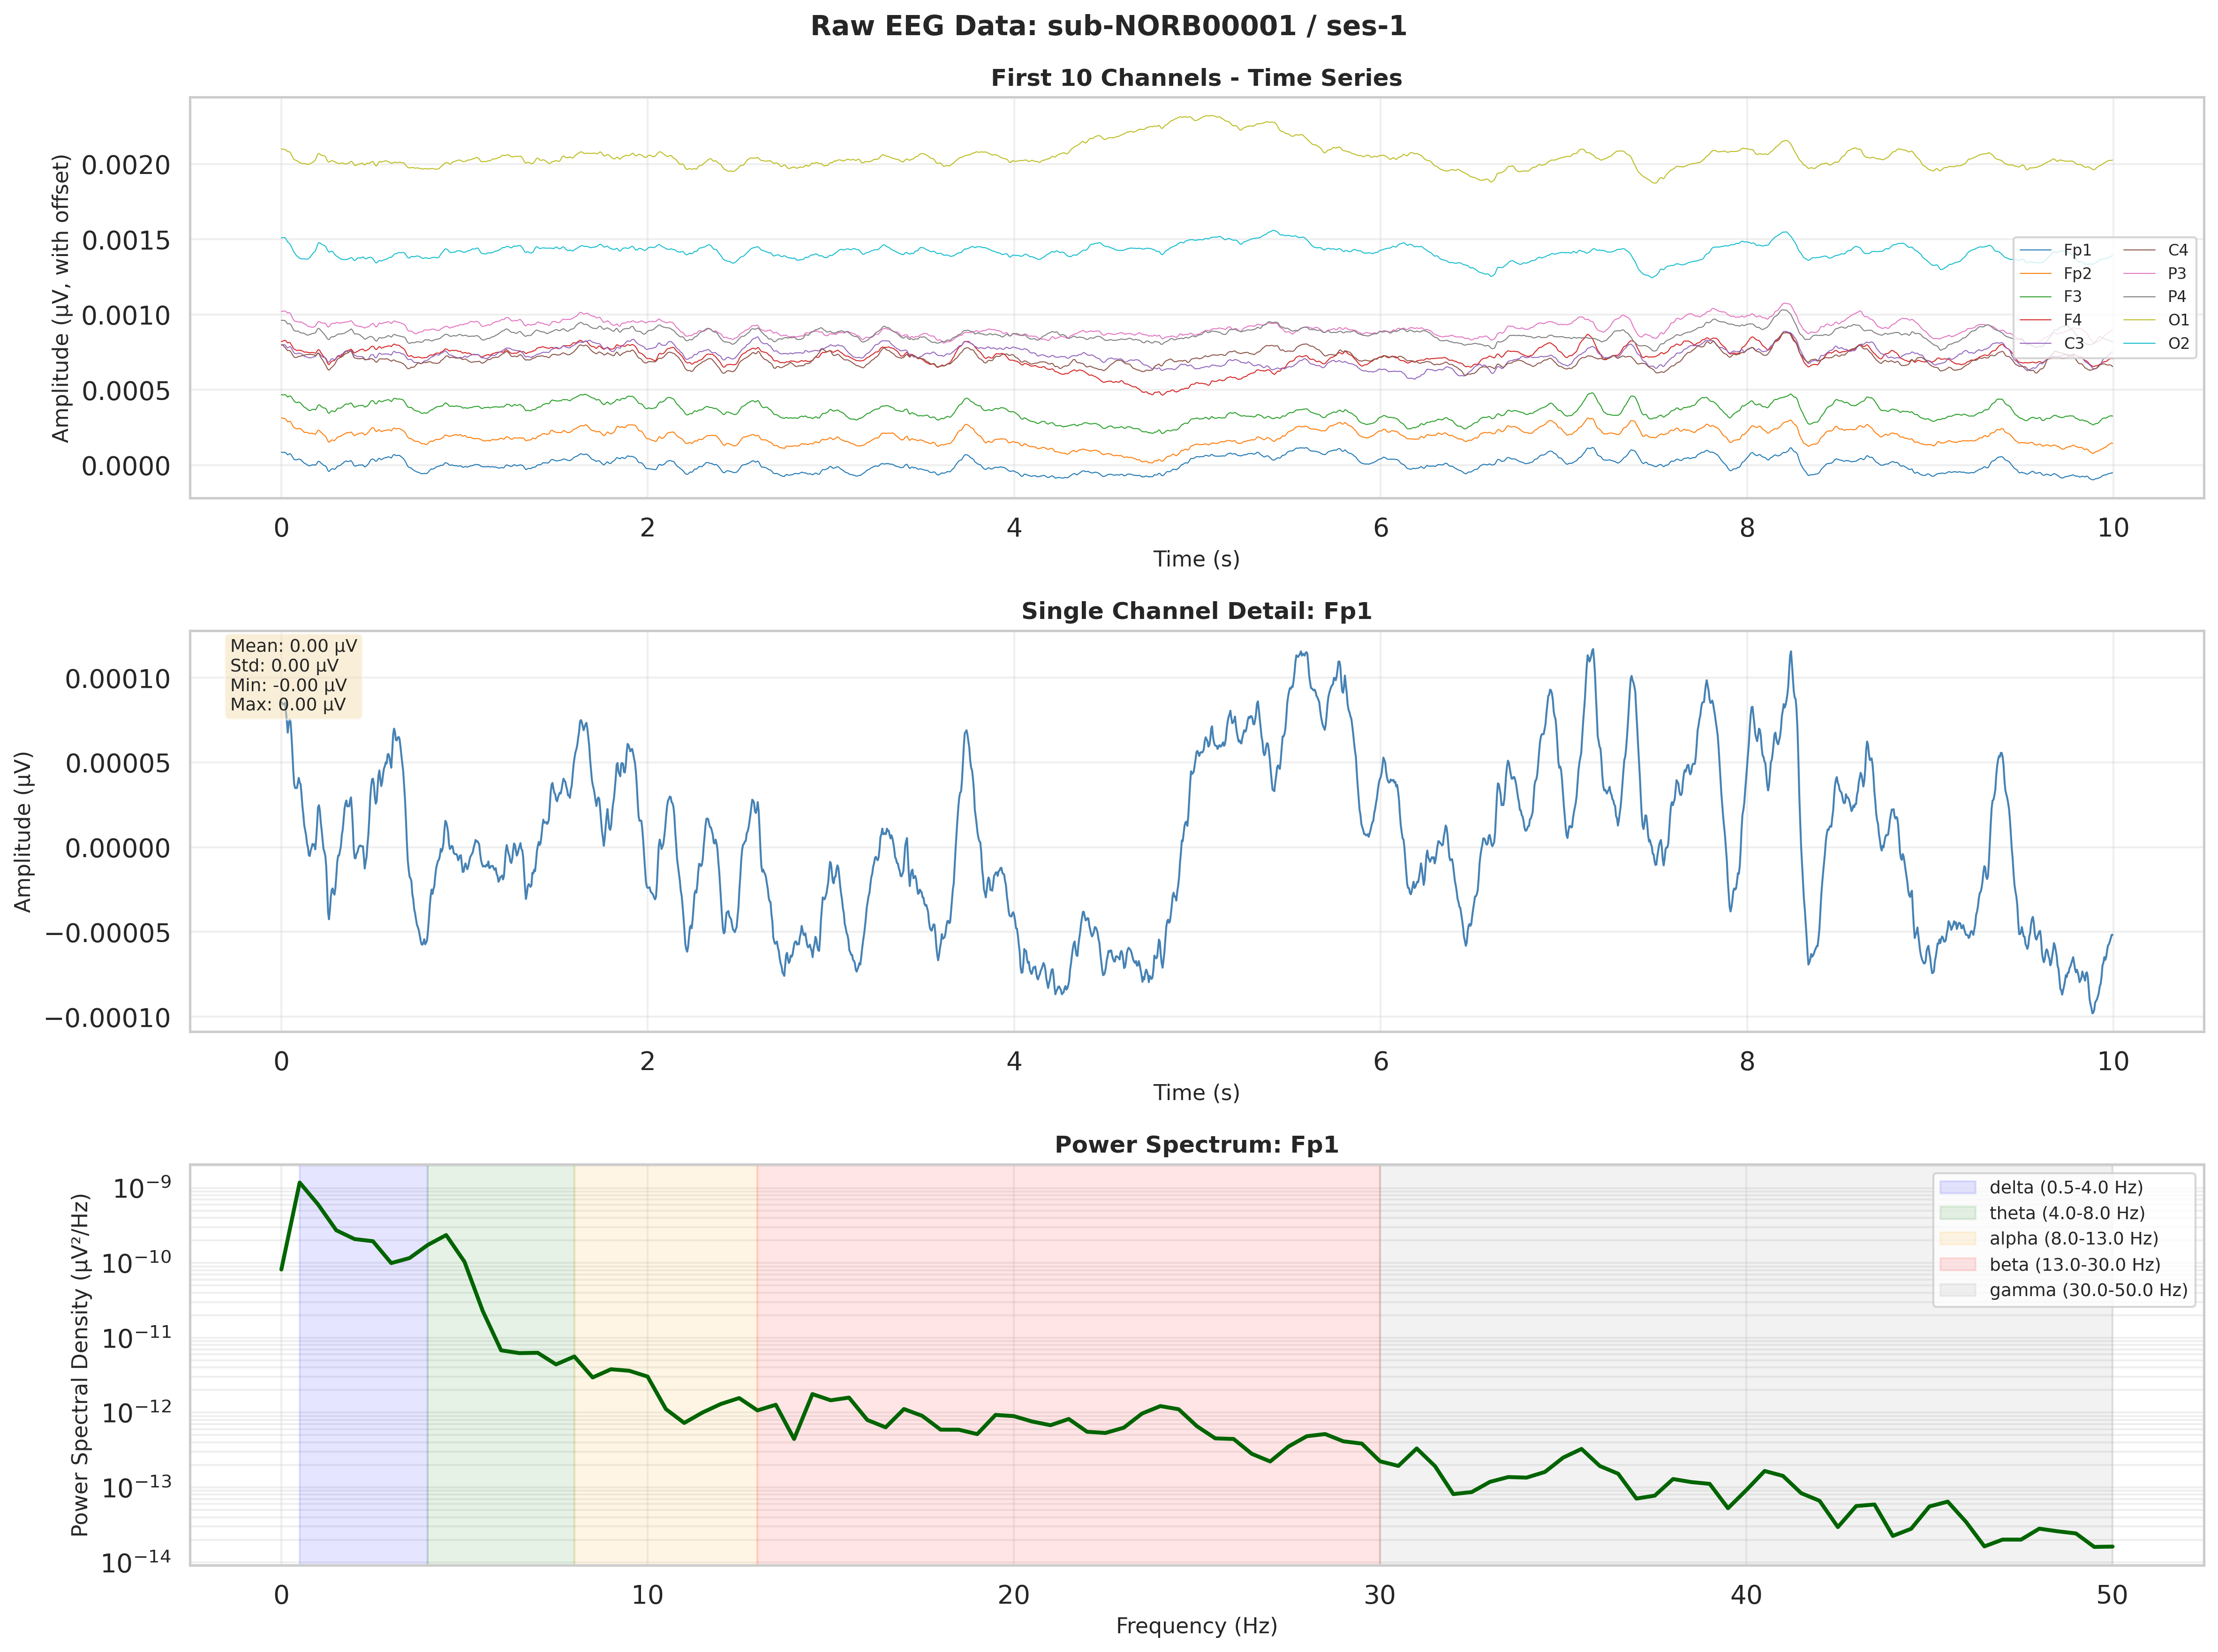


✓ Plot saved to: /home/alookaladdoo/DPCN-Project/results/quality_control/raw_eeg_sub-NORB00001_ses-1.png


In [20]:
# Visualize raw EEG from the first sample
if sample_results:
    sample = sample_results[0]
    raw = sample['raw']
    
    print(f"Visualizing: {sample['subject_id']} / {sample['session_id']}")
    print(f"Quality Score: {sample['quality_score']:.1f}/100")
    print()
    
    # Create visualization
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle(f"Raw EEG Data: {sample['subject_id']} / {sample['session_id']}", 
                 fontsize=14, fontweight='bold')
    
    # Get data (first 10 seconds)
    duration_to_plot = min(10, raw.n_times / raw.info['sfreq'])
    data, times = raw[:, :int(duration_to_plot * raw.info['sfreq'])]
    
    # Plot 1: All channels (overview)
    ax = axes[0]
    n_channels = min(10, len(raw.ch_names))  # Plot first 10 channels
    for i in range(n_channels):
        # Offset each channel for visibility
        offset = i * np.std(data[i]) * 3
        ax.plot(times, data[i] + offset, linewidth=0.5, label=raw.ch_names[i])
    
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Amplitude (µV, with offset)', fontsize=11)
    ax.set_title('First 10 Channels - Time Series', fontsize=12, fontweight='bold')
    ax.legend(loc='right', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Single channel detail (first channel)
    ax = axes[1]
    ax.plot(times, data[0], linewidth=1, color='steelblue')
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Amplitude (µV)', fontsize=11)
    ax.set_title(f'Single Channel Detail: {raw.ch_names[0]}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add amplitude statistics
    ax.text(0.02, 0.98, f'Mean: {np.mean(data[0]):.2f} µV\nStd: {np.std(data[0]):.2f} µV\nMin: {np.min(data[0]):.2f} µV\nMax: {np.max(data[0]):.2f} µV',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)
    
    # Plot 3: Power Spectral Density (first channel)
    ax = axes[2]
    from scipy import signal as sp_signal
    
    # Compute PSD using Welch's method
    freqs, psd = sp_signal.welch(data[0], fs=raw.info['sfreq'], nperseg=int(2*raw.info['sfreq']))
    
    # Plot only up to 50 Hz
    freq_mask = freqs <= 50
    ax.semilogy(freqs[freq_mask], psd[freq_mask], linewidth=2, color='darkgreen')
    ax.set_xlabel('Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Power Spectral Density (µV²/Hz)', fontsize=11)
    ax.set_title(f'Power Spectrum: {raw.ch_names[0]}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    
    # Mark frequency bands
    band_colors = {'delta': 'blue', 'theta': 'green', 'alpha': 'orange', 'beta': 'red'}
    for band_name, (fmin, fmax) in FREQUENCY_BANDS.items():
        if fmax <= 50:
            ax.axvspan(fmin, fmax, alpha=0.1, color=band_colors.get(band_name, 'gray'), 
                      label=f'{band_name} ({fmin}-{fmax} Hz)')
    
    ax.legend(loc='upper right', fontsize=9)
    
    plt.tight_layout()
    
    # Save figure
    qc_plot_path = OUTPUT_DIRS['qc'] / f'raw_eeg_{sample["subject_id"]}_{sample["session_id"]}.png'
    plt.savefig(qc_plot_path, dpi=FIGURE_DPI, bbox_inches='tight')
    logger.info(f"Saved raw EEG plot to {qc_plot_path}")
    
    plt.show()
    
    print(f"\n✓ Plot saved to: {qc_plot_path}")
else:
    print("No sample data available for visualization")

### Generate Data Quality Report

In [21]:
# Generate comprehensive quality report for sample sessions
quality_report_path = OUTPUT_DIRS['qc'] / 'sample_data_quality_report.txt'

with open(quality_report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("DATA QUALITY REPORT - SAMPLE SESSIONS\n")
    f.write("="*80 + "\n\n")
    f.write(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Number of sessions tested: {len(sample_results)}\n\n")
    
    for i, result in enumerate(sample_results, 1):
        f.write(f"\n{'-'*80}\n")
        f.write(f"SESSION {i}: {result['subject_id']} / {result['session_id']}\n")
        f.write(f"{'-'*80}\n\n")
        
        validation = result['validation']
        
        f.write("BASIC INFORMATION:\n")
        f.write(f"  Sampling Rate: {validation['sampling_rate']} Hz\n")
        f.write(f"  Number of Channels: {validation['n_channels']}\n")
        f.write(f"  Duration: {validation['duration_sec']:.1f} seconds\n")
        f.write(f"  Quality Score: {result['quality_score']:.1f}/100\n")
        f.write(f"  Overall Status: {'PASS' if validation['is_valid'] else 'FAIL'}\n\n")
        
        f.write("CHANNELS:\n")
        f.write(f"  {', '.join(validation['channel_names'])}\n\n")
        
        if validation['bad_channels']:
            f.write("BAD CHANNELS DETECTED:\n")
            for ch in validation['bad_channels']:
                f.write(f"  - {ch}\n")
            f.write("\n")
        
        if validation['flat_channels']:
            f.write("FLAT CHANNELS (zero variance):\n")
            for ch in validation['flat_channels']:
                f.write(f"  - {ch}\n")
            f.write("\n")
        
        f.write("VALIDATION CHECKS:\n")
        for check in validation['passed_checks']:
            f.write(f"  ✓ {check.replace('_', ' ').title()}\n")
        f.write("\n")
        
        if validation['warnings']:
            f.write("WARNINGS:\n")
            for warning in validation['warnings']:
                f.write(f"  ⚠ {warning}\n")
            f.write("\n")
        
        # Events information
        if result['events']['events'] is not None:
            f.write("EVENTS:\n")
            f.write(f"  Total events: {len(result['events']['events'])}\n")
            if 'trial_type' in result['events']['events'].columns:
                event_types = result['events']['events']['trial_type'].value_counts()
                for event_type, count in event_types.items():
                    f.write(f"    - {event_type}: {count}\n")
            f.write("\n")
        
        if result['events']['annotations'] is not None:
            f.write("ANNOTATIONS (from derivatives):\n")
            f.write(f"  Total annotations: {len(result['events']['annotations'])}\n")
            if 'trial_type' in result['events']['annotations'].columns:
                annot_types = result['events']['annotations']['trial_type'].value_counts()
                for annot_type, count in annot_types.items():
                    f.write(f"    - {annot_type}: {count}\n")
            f.write("\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("SUMMARY STATISTICS\n")
    f.write("="*80 + "\n\n")
    
    avg_quality = np.mean([r['quality_score'] for r in sample_results])
    avg_channels = np.mean([r['validation']['n_channels'] for r in sample_results])
    avg_duration = np.mean([r['validation']['duration_sec'] for r in sample_results])
    total_bad_channels = sum([len(r['validation']['bad_channels']) for r in sample_results])
    
    f.write(f"Average Quality Score: {avg_quality:.1f}/100\n")
    f.write(f"Average Number of Channels: {avg_channels:.1f}\n")
    f.write(f"Average Recording Duration: {avg_duration:.1f} seconds\n")
    f.write(f"Total Bad Channels Detected: {total_bad_channels}\n")
    f.write(f"Sessions with Issues: {sum([not r['validation']['is_valid'] for r in sample_results])}/{len(sample_results)}\n")

logger.info(f"Saved quality report to {quality_report_path}")
print(f"✓ Quality report saved to: {quality_report_path}")

# Display summary
print("\n" + "="*80)
print("QUALITY REPORT SUMMARY")
print("="*80)
print(f"Sessions tested: {len(sample_results)}")
print(f"Average quality score: {np.mean([r['quality_score'] for r in sample_results]):.1f}/100")
print(f"Sessions passed validation: {sum([r['validation']['is_valid'] for r in sample_results])}/{len(sample_results)}")
print(f"Total bad channels: {sum([len(r['validation']['bad_channels']) for r in sample_results])}")
print(f"\nReport saved to: {quality_report_path}")

print(f"\n{'='*80}")
print("SECTION 4 COMPLETE: Data Loading and Validation")
print(f"{'='*80}")

2025-10-25 14:49:23 - GrangerCausality - INFO - Saved quality report to /home/alookaladdoo/DPCN-Project/results/quality_control/sample_data_quality_report.txt
✓ Quality report saved to: /home/alookaladdoo/DPCN-Project/results/quality_control/sample_data_quality_report.txt

QUALITY REPORT SUMMARY
Sessions tested: 3
Average quality score: 100.0/100
Sessions passed validation: 3/3
Total bad channels: 1

Report saved to: /home/alookaladdoo/DPCN-Project/results/quality_control/sample_data_quality_report.txt

SECTION 4 COMPLETE: Data Loading and Validation
✓ Quality report saved to: /home/alookaladdoo/DPCN-Project/results/quality_control/sample_data_quality_report.txt

QUALITY REPORT SUMMARY
Sessions tested: 3
Average quality score: 100.0/100
Sessions passed validation: 3/3
Total bad channels: 1

Report saved to: /home/alookaladdoo/DPCN-Project/results/quality_control/sample_data_quality_report.txt

SECTION 4 COMPLETE: Data Loading and Validation


---
## Section 5: Preprocessing Pipeline

Clean and prepare EEG data for Granger causality analysis.

### Preprocessing Functions

In [22]:
def preprocess_eeg(raw, subject_id=None, session_id=None, bad_channels=None):
    """
    Preprocess EEG data with filtering, referencing, and bad channel handling.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Raw EEG data object
    subject_id : str, optional
        Subject identifier for logging
    session_id : str, optional
        Session identifier for logging
    bad_channels : list, optional
        List of bad channels to mark (in addition to auto-detected)
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'raw_preprocessed': Preprocessed Raw object
        - 'bad_channels': List of channels marked as bad
        - 'interpolated_channels': List of channels that were interpolated
        - 'preprocessing_steps': List of applied preprocessing steps
    """
    session_label = f"{subject_id}/{session_id}" if subject_id and session_id else "data"
    logger.info(f"Starting preprocessing for {session_label}")
    
    # Create a copy to avoid modifying original
    raw_prep = raw.copy()
    
    preprocessing_steps = []
    
    # Step 1: Mark bad channels
    if bad_channels is None:
        bad_channels = []
    
    # Add any pre-marked bad channels
    if raw_prep.info['bads']:
        bad_channels.extend(raw_prep.info['bads'])
    
    raw_prep.info['bads'] = list(set(bad_channels))  # Remove duplicates
    
    if raw_prep.info['bads']:
        logger.info(f"{session_label}: Marked {len(raw_prep.info['bads'])} bad channels: {raw_prep.info['bads']}")
        preprocessing_steps.append(f"marked_{len(raw_prep.info['bads'])}_bad_channels")
    
    # Step 2: Apply bandpass filter
    logger.info(f"{session_label}: Applying bandpass filter {HIGHPASS_FREQ}-{LOWPASS_FREQ} Hz")
    raw_prep.filter(
        l_freq=HIGHPASS_FREQ,
        h_freq=LOWPASS_FREQ,
        picks='eeg',
        method='fir',
        fir_design='firwin',
        verbose='ERROR'
    )
    preprocessing_steps.append(f"bandpass_{HIGHPASS_FREQ}_{LOWPASS_FREQ}Hz")
    
    # Step 3: Apply notch filter for power line noise
    logger.info(f"{session_label}: Applying notch filter at {NOTCH_FREQ} Hz")
    raw_prep.notch_filter(
        freqs=NOTCH_FREQ,
        picks='eeg',
        method='fir',
        fir_design='firwin',
        verbose='ERROR'
    )
    preprocessing_steps.append(f"notch_{NOTCH_FREQ}Hz")
    
    # Step 4: Resample if needed
    if TARGET_SFREQ and abs(raw_prep.info['sfreq'] - TARGET_SFREQ) > 0.1:
        logger.info(f"{session_label}: Resampling from {raw_prep.info['sfreq']} to {TARGET_SFREQ} Hz")
        raw_prep.resample(TARGET_SFREQ, npad='auto', verbose='ERROR')
        preprocessing_steps.append(f"resampled_{TARGET_SFREQ}Hz")
    
    # Step 5: Interpolate bad channels
    interpolated_channels = []
    if INTERPOLATE_BAD_CHANNELS and raw_prep.info['bads']:
        logger.info(f"{session_label}: Interpolating {len(raw_prep.info['bads'])} bad channels")
        try:
            raw_prep.interpolate_bads(reset_bads=True, verbose='ERROR')
            interpolated_channels = raw_prep.info['bads'].copy()
            preprocessing_steps.append(f"interpolated_{len(interpolated_channels)}_channels")
        except Exception as e:
            logger.warning(f"{session_label}: Could not interpolate bad channels: {e}")
    
    # Step 6: Re-reference
    if REFERENCE_TYPE:
        if REFERENCE_TYPE.lower() == 'average':
            logger.info(f"{session_label}: Applying average reference")
            raw_prep.set_eeg_reference('average', projection=False, verbose='ERROR')
            preprocessing_steps.append("average_reference")
        elif REFERENCE_TYPE.lower() == 'common':
            logger.info(f"{session_label}: Using common reference (no change)")
            preprocessing_steps.append("common_reference")
    
    logger.info(f"{session_label}: Preprocessing complete")
    
    return {
        'raw_preprocessed': raw_prep,
        'bad_channels': bad_channels,
        'interpolated_channels': interpolated_channels,
        'preprocessing_steps': preprocessing_steps
    }


print("✓ Preprocessing function defined: preprocess_eeg()")

✓ Preprocessing function defined: preprocess_eeg()


### Segmentation Functions

In [23]:
def segment_data(raw, annotations=None, events=None, subject_id=None, session_id=None):
    """
    Segment EEG data into overlapping windows, optionally filtering by state (eyes closed).
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Preprocessed Raw EEG data
    annotations : pd.DataFrame, optional
        Annotations from derivatives (clean segments)
    events : pd.DataFrame, optional
        Events data (eyes open/closed markers)
    subject_id : str, optional
        Subject identifier for logging
    session_id : str, optional
        Session identifier for logging
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'segments': List of data arrays (channels × time)
        - 'segment_info': List of dicts with metadata per segment
        - 'n_segments': Total number of segments
        - 'total_duration': Total duration of all segments
    """
    session_label = f"{subject_id}/{session_id}" if subject_id and session_id else "data"
    logger.info(f"Segmenting data for {session_label}")
    
    sfreq = raw.info['sfreq']
    duration = raw.n_times / sfreq
    window_samples = int(WINDOW_LENGTH * sfreq)
    step_samples = int(window_samples * (1 - WINDOW_OVERLAP))
    
    segments = []
    segment_info = []
    
    # Determine valid time ranges
    if USE_EYES_CLOSED_ONLY and events is not None and 'trial_type' in events.columns:
        # Extract eyes-closed periods
        eyes_closed_events = events[events['trial_type'].str.contains('eyes_closed', case=False, na=False)]
        
        if len(eyes_closed_events) > 0:
            logger.info(f"{session_label}: Found {len(eyes_closed_events)} eyes-closed events")
            valid_ranges = []
            
            for _, event in eyes_closed_events.iterrows():
                start_time = event['onset']
                end_time = start_time + event.get('duration', MIN_EYES_CLOSED_DURATION)
                
                if end_time - start_time >= MIN_EYES_CLOSED_DURATION:
                    valid_ranges.append((start_time, end_time))
        else:
            logger.warning(f"{session_label}: No eyes-closed events found, using all data")
            valid_ranges = [(0, duration)]
    else:
        # Use all data
        valid_ranges = [(0, duration)]
        logger.info(f"{session_label}: Using all available data")
    
    # Additional filtering based on derivative annotations (clean segments)
    if USE_DERIVATIVE_ANNOTATIONS and annotations is not None and len(annotations) > 0:
        clean_ranges = []
        for _, annot in annotations.iterrows():
            if 'clean' in str(annot.get('trial_type', '')).lower() or 'good' in str(annot.get('trial_type', '')).lower():
                clean_start = annot['onset']
                clean_end = clean_start + annot['duration']
                clean_ranges.append((clean_start, clean_end))
        
        if clean_ranges:
            logger.info(f"{session_label}: Applying {len(clean_ranges)} clean segment annotations")
            # Intersect valid_ranges with clean_ranges
            intersected_ranges = []
            for vr_start, vr_end in valid_ranges:
                for cr_start, cr_end in clean_ranges:
                    # Find overlap
                    overlap_start = max(vr_start, cr_start)
                    overlap_end = min(vr_end, cr_end)
                    if overlap_end > overlap_start:
                        intersected_ranges.append((overlap_start, overlap_end))
            
            if intersected_ranges:
                valid_ranges = intersected_ranges
            else:
                logger.warning(f"{session_label}: No overlap between eyes-closed and clean segments, using original ranges")
    
    # Create segments from valid ranges
    for range_idx, (start_time, end_time) in enumerate(valid_ranges):
        range_duration = end_time - start_time
        
        if range_duration < WINDOW_LENGTH:
            logger.debug(f"{session_label}: Skipping range {range_idx} (too short: {range_duration:.1f}s)")
            continue
        
        # Generate overlapping windows within this range
        start_sample = int(start_time * sfreq)
        end_sample = int(end_time * sfreq)
        
        current_sample = start_sample
        while current_sample + window_samples <= end_sample:
            # Extract segment
            segment_data = raw.get_data(start=current_sample, stop=current_sample + window_samples)
            
            # Check for artifacts (simple amplitude threshold)
            max_amplitude = np.max(np.abs(segment_data))
            if max_amplitude < AMPLITUDE_THRESHOLD:
                segments.append(segment_data)
                segment_info.append({
                    'segment_id': len(segments) - 1,
                    'start_time': current_sample / sfreq,
                    'end_time': (current_sample + window_samples) / sfreq,
                    'duration': WINDOW_LENGTH,
                    'max_amplitude': max_amplitude,
                    'range_id': range_idx
                })
            else:
                logger.debug(f"{session_label}: Rejected segment at {current_sample/sfreq:.1f}s (amplitude: {max_amplitude:.1f} µV)")
            
            # Move to next window
            current_sample += step_samples
            
            # Check if we've reached the maximum number of segments
            if len(segments) >= MAX_SEGMENTS_PER_SESSION:
                break
        
        if len(segments) >= MAX_SEGMENTS_PER_SESSION:
            break
    
    total_duration = len(segments) * WINDOW_LENGTH if segments else 0
    
    logger.info(f"{session_label}: Created {len(segments)} segments (total: {total_duration:.1f}s)")
    
    if len(segments) < MIN_SEGMENTS_PER_SESSION:
        logger.warning(f"{session_label}: Only {len(segments)} segments (minimum: {MIN_SEGMENTS_PER_SESSION})")
    
    return {
        'segments': segments,
        'segment_info': segment_info,
        'n_segments': len(segments),
        'total_duration': total_duration
    }


print("✓ Segmentation function defined: segment_data()")

✓ Segmentation function defined: segment_data()


### Stationarity Testing

In [24]:
def check_stationarity(segment_data, channel_names=None, alpha=None):
    """
    Test stationarity of each channel using Augmented Dickey-Fuller test.
    
    Parameters:
    -----------
    segment_data : np.ndarray
        Data array (channels × time)
    channel_names : list, optional
        List of channel names
    alpha : float, optional
        Significance level (default from config)
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'is_stationary': Boolean array per channel
        - 'adf_statistics': ADF test statistics per channel
        - 'p_values': P-values per channel
        - 'n_stationary': Number of stationary channels
        - 'percent_stationary': Percentage of stationary channels
    """
    if alpha is None:
        alpha = STATIONARITY_ALPHA
    
    n_channels = segment_data.shape[0]
    if channel_names is None:
        channel_names = [f"Ch{i+1}" for i in range(n_channels)]
    
    is_stationary = np.zeros(n_channels, dtype=bool)
    adf_statistics = np.zeros(n_channels)
    p_values = np.zeros(n_channels)
    
    for i in range(n_channels):
        try:
            # Perform Augmented Dickey-Fuller test
            result = adfuller(segment_data[i, :], autolag='AIC')
            adf_statistics[i] = result[0]
            p_values[i] = result[1]
            
            # Stationary if we reject null hypothesis (p < alpha)
            is_stationary[i] = p_values[i] < alpha
            
        except Exception as e:
            logger.debug(f"ADF test failed for channel {channel_names[i]}: {e}")
            is_stationary[i] = False
            adf_statistics[i] = np.nan
            p_values[i] = 1.0
    
    n_stationary = np.sum(is_stationary)
    percent_stationary = (n_stationary / n_channels) * 100
    
    return {
        'is_stationary': is_stationary,
        'adf_statistics': adf_statistics,
        'p_values': p_values,
        'n_stationary': n_stationary,
        'percent_stationary': percent_stationary,
        'channel_names': channel_names
    }


def make_stationary(segment_data, method='difference'):
    """
    Apply transformation to make data stationary if needed.
    
    Parameters:
    -----------
    segment_data : np.ndarray
        Data array (channels × time)
    method : str
        Method to use ('difference' or 'detrend')
    
    Returns:
    --------
    np.ndarray : Transformed data
    """
    if method == 'difference':
        # First-order differencing
        return np.diff(segment_data, axis=1)
    elif method == 'detrend':
        # Remove linear trend
        from scipy.signal import detrend
        return detrend(segment_data, axis=1)
    else:
        return segment_data


print("✓ Stationarity functions defined:")
print("  - check_stationarity()")
print("  - make_stationary()")

✓ Stationarity functions defined:
  - check_stationarity()
  - make_stationary()


### Test Preprocessing on Sample Subject

In [25]:
# Test preprocessing pipeline on first sample subject
if sample_results:
    test_sample = sample_results[0]
    
    print("Testing preprocessing pipeline")
    print("="*80)
    print(f"Subject: {test_sample['subject_id']}")
    print(f"Session: {test_sample['session_id']}")
    print()
    
    # Get raw data and validation results
    raw_original = test_sample['raw']
    validation = test_sample['validation']
    
    print("Original data:")
    print(f"  Channels: {len(raw_original.ch_names)}")
    print(f"  Sampling rate: {raw_original.info['sfreq']} Hz")
    print(f"  Duration: {raw_original.n_times / raw_original.info['sfreq']:.1f} seconds")
    print(f"  Bad channels: {validation['bad_channels']}")
    print()
    
    # Apply preprocessing
    print("Applying preprocessing...")
    preprocess_result = preprocess_eeg(
        raw_original,
        subject_id=test_sample['subject_id'],
        session_id=test_sample['session_id'],
        bad_channels=validation['bad_channels']
    )
    
    raw_preprocessed = preprocess_result['raw_preprocessed']
    
    print("✓ Preprocessing complete")
    print(f"  Steps applied: {', '.join(preprocess_result['preprocessing_steps'])}")
    print(f"  Bad channels: {len(preprocess_result['bad_channels'])}")
    print(f"  Interpolated channels: {len(preprocess_result['interpolated_channels'])}")
    print()
    
    # Apply segmentation
    print("Applying segmentation...")
    segment_result = segment_data(
        raw_preprocessed,
        annotations=test_sample['events']['annotations'],
        events=test_sample['events']['events'],
        subject_id=test_sample['subject_id'],
        session_id=test_sample['session_id']
    )
    
    print("✓ Segmentation complete")
    print(f"  Number of segments: {segment_result['n_segments']}")
    print(f"  Total duration: {segment_result['total_duration']:.1f} seconds")
    print(f"  Average per segment: {WINDOW_LENGTH:.1f} seconds")
    print()
    
    # Test stationarity on first segment
    if segment_result['segments']:
        print("Testing stationarity on first segment...")
        first_segment = segment_result['segments'][0]
        
        stationarity_result = check_stationarity(
            first_segment,
            channel_names=raw_preprocessed.ch_names
        )
        
        print("✓ Stationarity test complete")
        print(f"  Stationary channels: {stationarity_result['n_stationary']}/{len(raw_preprocessed.ch_names)}")
        print(f"  Percentage stationary: {stationarity_result['percent_stationary']:.1f}%")
        
        non_stationary = [ch for ch, is_stat in zip(stationarity_result['channel_names'], 
                                                     stationarity_result['is_stationary']) if not is_stat]
        if non_stationary and len(non_stationary) < 10:
            print(f"  Non-stationary channels: {', '.join(non_stationary)}")
        
        # Store for visualization
        test_preprocessing_results = {
            'raw_original': raw_original,
            'raw_preprocessed': raw_preprocessed,
            'preprocess_result': preprocess_result,
            'segment_result': segment_result,
            'stationarity_result': stationarity_result,
            'subject_id': test_sample['subject_id'],
            'session_id': test_sample['session_id']
        }
    else:
        print("⚠ No segments created - cannot test stationarity")
        test_preprocessing_results = None
    
    print()
    print("="*80)
else:
    print("No sample data available for preprocessing test")
    test_preprocessing_results = None

Testing preprocessing pipeline
Subject: sub-NORB00001
Session: ses-1

Original data:
  Channels: 21
  Sampling rate: 200.0 Hz
  Duration: 714.0 seconds
  Bad channels: []

Applying preprocessing...
2025-10-25 14:49:23 - GrangerCausality - INFO - Starting preprocessing for sub-NORB00001/ses-1
2025-10-25 14:49:23 - GrangerCausality - INFO - sub-NORB00001/ses-1: Applying bandpass filter 0.5-30.0 Hz
2025-10-25 14:49:23 - GrangerCausality - INFO - sub-NORB00001/ses-1: Applying notch filter at 60.0 Hz
2025-10-25 14:49:23 - GrangerCausality - INFO - sub-NORB00001/ses-1: Applying average reference
2025-10-25 14:49:23 - GrangerCausality - INFO - sub-NORB00001/ses-1: Preprocessing complete
✓ Preprocessing complete
  Steps applied: bandpass_0.5_30.0Hz, notch_60.0Hz, average_reference
  Bad channels: 0
  Interpolated channels: 0

Applying segmentation...
2025-10-25 14:49:23 - GrangerCausality - INFO - Segmenting data for sub-NORB00001/ses-1
2025-10-25 14:49:23 - GrangerCausality - INFO - sub-NORB0

### Visualize Before/After Preprocessing

In [26]:
# Visualize preprocessing effects
if test_preprocessing_results:
    raw_orig = test_preprocessing_results['raw_original']
    raw_prep = test_preprocessing_results['raw_preprocessed']
    subj_id = test_preprocessing_results['subject_id']
    sess_id = test_preprocessing_results['session_id']
    
    print(f"Visualizing preprocessing effects: {subj_id} / {sess_id}")
    
    # Create comparison figure
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    fig.suptitle(f'Preprocessing Comparison: {subj_id} / {sess_id}', 
                 fontsize=14, fontweight='bold')
    
    # Get same time window from both
    duration_to_plot = min(10, raw_orig.n_times / raw_orig.info['sfreq'])
    n_samples = int(duration_to_plot * raw_orig.info['sfreq'])
    
    data_orig, times_orig = raw_orig[:, :n_samples]
    
    # For preprocessed (might have different sampling rate)
    n_samples_prep = int(duration_to_plot * raw_prep.info['sfreq'])
    data_prep, times_prep = raw_prep[:, :n_samples_prep]
    
    # Select first channel for detailed comparison
    ch_idx = 0
    ch_name = raw_orig.ch_names[ch_idx]
    
    # Row 1: Time series comparison
    ax = axes[0, 0]
    ax.plot(times_orig, data_orig[ch_idx], linewidth=0.8, color='steelblue', label='Original')
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Amplitude (µV)', fontsize=10)
    ax.set_title(f'Original - Channel: {ch_name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax = axes[0, 1]
    ax.plot(times_prep, data_prep[ch_idx], linewidth=0.8, color='darkgreen', label='Preprocessed')
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Amplitude (µV)', fontsize=10)
    ax.set_title(f'Preprocessed - Channel: {ch_name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Row 2: Power Spectral Density comparison
    from scipy import signal as sp_signal
    
    # Original PSD
    ax = axes[1, 0]
    freqs_orig, psd_orig = sp_signal.welch(data_orig[ch_idx], fs=raw_orig.info['sfreq'], nperseg=int(2*raw_orig.info['sfreq']))
    freq_mask = freqs_orig <= 50
    ax.semilogy(freqs_orig[freq_mask], psd_orig[freq_mask], linewidth=2, color='steelblue')
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('PSD (µV²/Hz)', fontsize=10)
    ax.set_title('Original - Power Spectrum', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    ax.axvline(NOTCH_FREQ, color='red', linestyle='--', alpha=0.5, label=f'{NOTCH_FREQ} Hz notch')
    ax.axvline(HIGHPASS_FREQ, color='orange', linestyle='--', alpha=0.5, label=f'{HIGHPASS_FREQ} Hz highpass')
    ax.axvline(LOWPASS_FREQ, color='purple', linestyle='--', alpha=0.5, label=f'{LOWPASS_FREQ} Hz lowpass')
    ax.legend(fontsize=8)
    
    # Preprocessed PSD
    ax = axes[1, 1]
    freqs_prep, psd_prep = sp_signal.welch(data_prep[ch_idx], fs=raw_prep.info['sfreq'], nperseg=int(2*raw_prep.info['sfreq']))
    freq_mask = freqs_prep <= 50
    ax.semilogy(freqs_prep[freq_mask], psd_prep[freq_mask], linewidth=2, color='darkgreen')
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('PSD (µV²/Hz)', fontsize=10)
    ax.set_title('Preprocessed - Power Spectrum', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, which='both')
    ax.axvline(NOTCH_FREQ, color='red', linestyle='--', alpha=0.5, label=f'{NOTCH_FREQ} Hz notch')
    ax.axvline(HIGHPASS_FREQ, color='orange', linestyle='--', alpha=0.5, label=f'{HIGHPASS_FREQ} Hz highpass')
    ax.axvline(LOWPASS_FREQ, color='purple', linestyle='--', alpha=0.5, label=f'{LOWPASS_FREQ} Hz lowpass')
    ax.legend(fontsize=8)
    
    # Row 3: Segment visualization
    segment_result = test_preprocessing_results['segment_result']
    
    ax = axes[2, 0]
    if segment_result['segments']:
        # Show first segment
        first_seg = segment_result['segments'][0]
        seg_times = np.arange(first_seg.shape[1]) / raw_prep.info['sfreq']
        
        # Plot multiple channels with offset
        n_ch_plot = min(5, first_seg.shape[0])
        for i in range(n_ch_plot):
            offset = i * np.std(first_seg[i]) * 2
            ax.plot(seg_times, first_seg[i] + offset, linewidth=0.7, label=raw_prep.ch_names[i])
        
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel('Amplitude (µV, with offset)', fontsize=10)
        ax.set_title(f'First Segment ({WINDOW_LENGTH}s window)', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8, loc='right')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No segments created', ha='center', va='center', 
                transform=ax.transAxes, fontsize=12)
        ax.set_title('Segment Visualization', fontsize=11, fontweight='bold')
    
    # Stationarity results
    ax = axes[2, 1]
    if test_preprocessing_results['stationarity_result']:
        stat_result = test_preprocessing_results['stationarity_result']
        
        # Bar plot of stationarity
        stationary_count = np.sum(stat_result['is_stationary'])
        non_stationary_count = len(stat_result['is_stationary']) - stationary_count
        
        bars = ax.bar(['Stationary', 'Non-stationary'], 
                      [stationary_count, non_stationary_count],
                      color=['green', 'red'], edgecolor='black', alpha=0.7)
        
        ax.set_ylabel('Number of Channels', fontsize=10)
        ax.set_title(f'Stationarity Test Results (α={STATIONARITY_ALPHA})', 
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontweight='bold')
        
        # Add percentage
        ax.text(0.5, 0.95, f'{stat_result["percent_stationary"]:.1f}% stationary',
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               fontsize=10, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No stationarity data', ha='center', va='center',
               transform=ax.transAxes, fontsize=12)
        ax.set_title('Stationarity Results', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    preproc_plot_path = OUTPUT_DIRS['qc'] / f'preprocessing_{subj_id}_{sess_id}.png'
    plt.savefig(preproc_plot_path, dpi=FIGURE_DPI, bbox_inches='tight')
    logger.info(f"Saved preprocessing comparison to {preproc_plot_path}")
    
    plt.show()
    
    print(f"\n✓ Preprocessing visualization saved to: {preproc_plot_path}")
else:
    print("No preprocessing results available for visualization")

No preprocessing results available for visualization


### Generate Preprocessing Summary Report

In [27]:
# Generate comprehensive preprocessing report
if test_preprocessing_results:
    preproc_report_path = OUTPUT_DIRS['qc'] / 'preprocessing_report.txt'
    
    with open(preproc_report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("PREPROCESSING PIPELINE REPORT\n")
        f.write("="*80 + "\n\n")
        f.write(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Subject: {test_preprocessing_results['subject_id']}\n")
        f.write(f"Session: {test_preprocessing_results['session_id']}\n\n")
        
        f.write("ORIGINAL DATA\n")
        f.write("-"*80 + "\n")
        raw_orig = test_preprocessing_results['raw_original']
        f.write(f"  Channels: {len(raw_orig.ch_names)}\n")
        f.write(f"  Sampling Rate: {raw_orig.info['sfreq']} Hz\n")
        f.write(f"  Duration: {raw_orig.n_times / raw_orig.info['sfreq']:.2f} seconds\n")
        f.write(f"  Total Samples: {raw_orig.n_times}\n\n")
        
        f.write("PREPROCESSING STEPS APPLIED\n")
        f.write("-"*80 + "\n")
        preproc = test_preprocessing_results['preprocess_result']
        for i, step in enumerate(preproc['preprocessing_steps'], 1):
            f.write(f"  {i}. {step.replace('_', ' ').title()}\n")
        f.write("\n")
        
        if preproc['bad_channels']:
            f.write("BAD CHANNELS\n")
            f.write("-"*80 + "\n")
            for ch in preproc['bad_channels']:
                f.write(f"  - {ch}\n")
            f.write("\n")
        
        if preproc['interpolated_channels']:
            f.write("INTERPOLATED CHANNELS\n")
            f.write("-"*80 + "\n")
            for ch in preproc['interpolated_channels']:
                f.write(f"  - {ch}\n")
            f.write("\n")
        
        f.write("PREPROCESSED DATA\n")
        f.write("-"*80 + "\n")
        raw_prep = test_preprocessing_results['raw_preprocessed']
        f.write(f"  Channels: {len(raw_prep.ch_names)}\n")
        f.write(f"  Sampling Rate: {raw_prep.info['sfreq']} Hz\n")
        f.write(f"  Duration: {raw_prep.n_times / raw_prep.info['sfreq']:.2f} seconds\n")
        f.write(f"  Total Samples: {raw_prep.n_times}\n\n")
        
        f.write("SEGMENTATION RESULTS\n")
        f.write("-"*80 + "\n")
        seg_result = test_preprocessing_results['segment_result']
        f.write(f"  Number of Segments: {seg_result['n_segments']}\n")
        f.write(f"  Total Duration: {seg_result['total_duration']:.2f} seconds\n")
        f.write(f"  Window Length: {WINDOW_LENGTH} seconds\n")
        f.write(f"  Window Overlap: {WINDOW_OVERLAP*100:.0f}%\n")
        f.write(f"  Minimum Required: {MIN_SEGMENTS_PER_SESSION} segments\n")
        f.write(f"  Status: {'PASS' if seg_result['n_segments'] >= MIN_SEGMENTS_PER_SESSION else 'FAIL'}\n\n")
        
        if seg_result['segment_info']:
            f.write("SEGMENT DETAILS (first 5)\n")
            f.write("-"*80 + "\n")
            for seg_info in seg_result['segment_info'][:5]:
                f.write(f"  Segment {seg_info['segment_id']}: ")
                f.write(f"{seg_info['start_time']:.2f}s - {seg_info['end_time']:.2f}s, ")
                f.write(f"max amplitude: {seg_info['max_amplitude']:.2f} µV\n")
            f.write("\n")
        
        f.write("STATIONARITY TEST RESULTS\n")
        f.write("-"*80 + "\n")
        stat_result = test_preprocessing_results['stationarity_result']
        f.write(f"  Test: Augmented Dickey-Fuller\n")
        f.write(f"  Significance Level: α = {STATIONARITY_ALPHA}\n")
        f.write(f"  Stationary Channels: {stat_result['n_stationary']}/{len(raw_prep.ch_names)}\n")
        f.write(f"  Percentage: {stat_result['percent_stationary']:.1f}%\n\n")
        
        non_stationary = [ch for ch, is_stat in zip(stat_result['channel_names'], 
                                                     stat_result['is_stationary']) if not is_stat]
        if non_stationary:
            f.write("  Non-Stationary Channels:\n")
            for ch in non_stationary:
                idx = stat_result['channel_names'].index(ch)
                f.write(f"    - {ch}: ADF={stat_result['adf_statistics'][idx]:.4f}, ")
                f.write(f"p={stat_result['p_values'][idx]:.4f}\n")
            f.write("\n")
        
        f.write("FILTERING PARAMETERS USED\n")
        f.write("-"*80 + "\n")
        f.write(f"  High-pass Filter: {HIGHPASS_FREQ} Hz\n")
        f.write(f"  Low-pass Filter: {LOWPASS_FREQ} Hz\n")
        f.write(f"  Notch Filter: {NOTCH_FREQ} Hz\n")
        f.write(f"  Target Sampling Rate: {TARGET_SFREQ} Hz\n")
        f.write(f"  Reference Type: {REFERENCE_TYPE}\n")
        f.write(f"  Amplitude Threshold: {AMPLITUDE_THRESHOLD} µV\n\n")
        
        f.write("="*80 + "\n")
    
    logger.info(f"Saved preprocessing report to {preproc_report_path}")
    print(f"✓ Preprocessing report saved to: {preproc_report_path}")
    
    # Display summary
    print("\n" + "="*80)
    print("PREPROCESSING SUMMARY")
    print("="*80)
    print(f"Subject: {test_preprocessing_results['subject_id']} / {test_preprocessing_results['session_id']}")
    print(f"Steps applied: {len(preproc['preprocessing_steps'])}")
    print(f"Segments created: {seg_result['n_segments']}")
    print(f"Stationary channels: {stat_result['n_stationary']}/{len(raw_prep.ch_names)} ({stat_result['percent_stationary']:.1f}%)")
    print(f"Status: {'✓ READY for GC analysis' if seg_result['n_segments'] >= MIN_SEGMENTS_PER_SESSION else '✗ INSUFFICIENT segments'}")
    
    print(f"\n{'='*80}")
    print("SECTION 5 COMPLETE: Preprocessing Pipeline")
    print(f"{'='*80}")
else:
    print("No preprocessing results available for report generation")

No preprocessing results available for report generation
